<a href="https://colab.research.google.com/github/Taise-Kojima/HomeCredit_cmp/blob/main/HomeCredit_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
!pip install optuna
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import re
import pickle
import gc
import optuna

# scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# LightGBM
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [258]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [259]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。

INPUT_DIR = "/content/drive/My Drive/GCI/cmp2/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
"""
df = pd.read_csv(INPUT + 'kaggle/application_train.csv')
test_df = pd.read_csv(INPUT + 'kaggle/application_test.csv')
sample_df = pd.read_csv(INPUT + 'kaggle/sample_submission.csv')
"""

"\ndf = pd.read_csv(INPUT + 'kaggle/application_train.csv')\ntest_df = pd.read_csv(INPUT + 'kaggle/application_test.csv')\nsample_df = pd.read_csv(INPUT + 'kaggle/sample_submission.csv')\n"

In [260]:
# コンペのデータセットのファイルパス
"""
INPUT_DIR = "/content/drive/My Drive/GCI/cmp2/"
train_comp = pd.read_csv(INPUT_DIR + "train.csv")
test_comp = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub_comp = pd.read_csv(INPUT_DIR + "sample_submission.csv")

# Kaggleのデータセットのファイルパス
INPUT_KAGGLE_DIR = "/content/drive/My Drive/GCI/cmp2/kaggle/"
train_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + 'application_train.csv')
test_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + 'application_test.csv')
sample_sub_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + 'sample_submission.csv')

# コンペデータのカラムに存在するカラムのみを選択
common_columns_train = train_comp.columns.intersection(train_kaggle.columns)
common_columns_test = test_comp.columns.intersection(test_kaggle.columns)

train = train_kaggle[common_columns_train]
test = test_kaggle[common_columns_test]
"""

'\nINPUT_DIR = "/content/drive/My Drive/GCI/cmp2/"\ntrain_comp = pd.read_csv(INPUT_DIR + "train.csv")\ntest_comp = pd.read_csv(INPUT_DIR + "test.csv")\nsample_sub_comp = pd.read_csv(INPUT_DIR + "sample_submission.csv")\n\n# Kaggleのデータセットのファイルパス\nINPUT_KAGGLE_DIR = "/content/drive/My Drive/GCI/cmp2/kaggle/"\ntrain_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + \'application_train.csv\')\ntest_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + \'application_test.csv\')\nsample_sub_kaggle = pd.read_csv(INPUT_KAGGLE_DIR + \'sample_submission.csv\')\n\n# コンペデータのカラムに存在するカラムのみを選択\ncommon_columns_train = train_comp.columns.intersection(train_kaggle.columns)\ncommon_columns_test = test_comp.columns.intersection(test_kaggle.columns)\n\ntrain = train_kaggle[common_columns_train]\ntest = test_kaggle[common_columns_test]\n'

In [261]:

#ダウンサンプリング 1対10から1対7にする

# クラスごとのデータを分ける
class_0 = train[train['TARGET'] == 0]
class_1 = train[train['TARGET'] == 1]

# クラス1のサンプル数を取得
n_class_1 = len(class_1)

# クラス0をダウンサンプリングして、クラス1のサンプル数の4倍にする
n_samples_class_0 = n_class_1 * 7
class_0_downsampled = resample(class_0,
                               replace=False,  # サンプルの重複を許可しない
                               n_samples=n_samples_class_0,  # クラス1のサンプル数の4倍にする
                               random_state=42)  # 再現性のためのシード

# ダウンサンプリングされたデータとクラス1のデータを結合
train_downsampled = pd.concat([class_0_downsampled, class_1])

# シャッフルしてデータセットを混ぜる
train = train_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)


In [262]:
#フラグの平均、分散、合計
flag_columns = ['FLAG_OWN_CAR',
                 'FLAG_OWN_REALTY',
                 'FLAG_MOBIL',
                 'FLAG_EMP_PHONE',
                 'FLAG_WORK_PHONE',
                 'FLAG_CONT_MOBILE',
                 'FLAG_PHONE',
                 'FLAG_EMAIL',
                 'REG_REGION_NOT_LIVE_REGION',
                 'REG_REGION_NOT_WORK_REGION',
                 'LIVE_REGION_NOT_WORK_REGION',
                 'REG_CITY_NOT_WORK_CITY',
                 'LIVE_CITY_NOT_WORK_CITY']

# FLAG_OWN_CARとFLAG_OWN_REALTYを数値データに変換
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)


train['FLAG_AVELEGE'] = train[flag_columns].mean(axis=1)
test['FLAG_AVELEGE'] = test[flag_columns].mean(axis=1)
train['FLAG_STD'] = train[flag_columns].std(axis=1)
test['FLAG_STD'] = test[flag_columns].std(axis=1)
train['FLAG_SUM'] = train[flag_columns].sum(axis=1)
test['FLAG_SUM'] = test[flag_columns].sum(axis=1)


In [263]:
print(train['CNT_FAM_MEMBERS'].dtype)

# CNT_FAM_MEMBERS を数値型に強制変換
train['CNT_FAM_MEMBERS'] = pd.to_numeric(train['CNT_FAM_MEMBERS'], errors='coerce')
test['CNT_FAM_MEMBERS'] = pd.to_numeric(test['CNT_FAM_MEMBERS'], errors='coerce')

# 平均値を再計算
TRAIN_CNT_FAM_MEMBERS_MEAN = train['CNT_FAM_MEMBERS'].mean()
TEST_CNT_FAM_MEMBERS_MEAN = test['CNT_FAM_MEMBERS'].mean()

# 欠損値を平均値で埋める
train['CNT_FAM_MEMBERS'].fillna(TRAIN_CNT_FAM_MEMBERS_MEAN, inplace=True)
test['CNT_FAM_MEMBERS'].fillna(TEST_CNT_FAM_MEMBERS_MEAN, inplace=True)

# 結果の確認
print("Updated Train CNT_FAM_MEMBERS Mean:", TRAIN_CNT_FAM_MEMBERS_MEAN)
print("Updated Test CNT_FAM_MEMBERS Mean:", TEST_CNT_FAM_MEMBERS_MEAN)

float64
Updated Train CNT_FAM_MEMBERS Mean: 2.154694933342981
Updated Test CNT_FAM_MEMBERS Mean: 2.153593495934959


In [264]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.isnull().sum())

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        3
AMT_GOODS_PRICE                  104
NAME_TYPE_SUITE                  466
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                    73134
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [265]:
train_income_org = train.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].median().to_dict()
train['ORGANIZATIOM_MEDIAN'] = train['ORGANIZATION_TYPE'].map(train_income_org)

test_income_org = test.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].median().to_dict()
test['ORGANIZATIOM_MEDIAN'] = test['ORGANIZATION_TYPE'].map(test_income_org)

train['ORGANIZATION_DIFFERNCE'] = train['AMT_INCOME_TOTAL'] - train['ORGANIZATIOM_MEDIAN']
test['ORGANIZATION_DIFFERNCE'] = test['AMT_INCOME_TOTAL'] - test['ORGANIZATIOM_MEDIAN']


In [266]:
train["DAYS_ID_PUBLISH"] = train["DAYS_ID_PUBLISH"].abs()
test["DAYS_ID_PUBLISH"] = test["DAYS_ID_PUBLISH"].abs()

"""
import matplotlib.pyplot as plt
# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割
train['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))

# 各ビンで TARGET が 1 の割合を計算
grouped = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean() * 100  # 結果をパーセンテージで

# 可視化
plt.figure(figsize=(10, 6))
grouped.plot(kind='bar', color='skyblue')
plt.title('TARGET = 1の割合（DAYS_ID_PUBLISH毎の500日間隔のビン）')
plt.xlabel('DAYS_ID_PUBLISH Bin')
plt.ylabel('TARGET = 1の割合 (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
"""

"\nimport matplotlib.pyplot as plt\n# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割\ntrain['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))\n\n# 各ビンで TARGET が 1 の割合を計算\ngrouped = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean() * 100  # 結果をパーセンテージで\n\n# 可視化\nplt.figure(figsize=(10, 6))\ngrouped.plot(kind='bar', color='skyblue')\nplt.title('TARGET = 1の割合（DAYS_ID_PUBLISH毎の500日間隔のビン）')\nplt.xlabel('DAYS_ID_PUBLISH Bin')\nplt.ylabel('TARGET = 1の割合 (%)')\nplt.xticks(rotation=45)\nplt.grid(True)\nplt.show()\n"

In [267]:
"""
# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割
train['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))
test['DAYS_ID_PUBLISH_BIN'] = pd.cut(test['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))

# trainデータセットで TARGET が 1 の割合を計算
rate_per_bin = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean()

# 新しい特徴量 'DAYS_ID_PUBLISH_RATE' を追加
train['DAYS_ID_PUBLISH_RATE'] = train['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)
test['DAYS_ID_PUBLISH_RATE'] = test['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)
"""

"\n# 'DAYS_ID_PUBLISH' を 500 の間隔でビン分割\ntrain['DAYS_ID_PUBLISH_BIN'] = pd.cut(train['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))\ntest['DAYS_ID_PUBLISH_BIN'] = pd.cut(test['DAYS_ID_PUBLISH'], bins=range(int(train['DAYS_ID_PUBLISH'].min()), int(train['DAYS_ID_PUBLISH'].max()) + 500, 500))\n\n# trainデータセットで TARGET が 1 の割合を計算\nrate_per_bin = train.groupby('DAYS_ID_PUBLISH_BIN')['TARGET'].mean()\n\n# 新しい特徴量 'DAYS_ID_PUBLISH_RATE' を追加\ntrain['DAYS_ID_PUBLISH_RATE'] = train['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)\ntest['DAYS_ID_PUBLISH_RATE'] = test['DAYS_ID_PUBLISH_BIN'].map(rate_per_bin)\n"

In [268]:
# AMT_ANNUITYの平均値を計算
mean_amt_annuity = train['AMT_ANNUITY'].mean()
mean_amt_annuity_test = test['AMT_ANNUITY'].mean()

# 欠損値を平均値で補完
train['AMT_ANNUITY'].fillna(mean_amt_annuity, inplace=True)
test['AMT_ANNUITY'].fillna(mean_amt_annuity_test, inplace=True)

mean_amt_annuity = train['AMT_GOODS_PRICE'].mean()
train['AMT_GOODS_PRICE'].fillna(mean_amt_annuity, inplace=True)

mean_amt_annuity_test = test['AMT_GOODS_PRICE'].mean()
test['AMT_GOODS_PRICE'].fillna(mean_amt_annuity_test, inplace=True)

# EXT_SOURCE_2の欠損値を平均値で補完
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)

In [269]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.isnull().sum())

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        0
AMT_GOODS_PRICE                    0
NAME_TYPE_SUITE                  466
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                    73134
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [270]:
train['DAYS_EMPLOYED_REC'] = train['DAYS_EMPLOYED'] - train['DAYS_BIRTH']
test['DAYS_EMPLOYED_REC'] = test['DAYS_EMPLOYED'] - test['DAYS_BIRTH']
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
train['CHILDREM_RAITON'] = train['CNT_CHILDREN'] / train['CNT_FAM_MEMBERS']
test['CHILDREM_RAITON'] = test['CNT_CHILDREN'] / test['CNT_FAM_MEMBERS']


In [271]:

train['DSCR'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] * 100 #収入に対する年間返済額
train['Repayment_Rate'] = train['AMT_ANNUITY'] / train['AMT_CREDIT'] * 100 #返済率
train['DTI'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL'] #DTI クライアントがどれだけの負債を背負っているか
# 返済率が4.65%を超えるかどうかに基づいて新しい特徴量を作成
train['High_Repayment'] = (train['Repayment_Rate'] > 4.65).astype(int)


In [272]:
"""
# High_Repaymentが1で、TARGETも1のデータのみをフィルタリング
target_1_high_repayment = train[(train['High_Repayment'] == 1) & (train['TARGET'] == 1)]

# High_Repaymentが1で、TARGETも1のデータ数をカウント
count_target_1 = target_1_high_repayment.shape[0]

# High Repaymentのデータの総数
count_high_repayment = train[train['High_Repayment'] == 1].shape[0]
# TARGETの全データの数
total_target_count = train['TARGET'].count()

# TARGETが1のデータの数をカウント
count_target_1_total = train[train['TARGET'] == 1].shape[0]

# 全データの数
total_count = train.shape[0]


# TARGETの総数（非欠損値の数）
total_target_count = train['TARGET'].count()

# TARGETが1の割合を計算
percentage_target_1 = (count_target_1_total / total_count) * 100

# 結果を表示
print(f"全データの中でTARGETが1のデータの数: {count_target_1_total}, TARGETの総数:{total_target_count}, 全データにおけるTARGETが1の割合: {percentage_target_1:.2f}%")
print(f"High Repaymentの中でTARGETが1のデータの数: {count_target_1}, High Repaymentの総数: {count_high_repayment}, 割合は: {count_target_1/count_high_repayment * 100:.2f}%")
"""

'\n# High_Repaymentが1で、TARGETも1のデータのみをフィルタリング\ntarget_1_high_repayment = train[(train[\'High_Repayment\'] == 1) & (train[\'TARGET\'] == 1)]\n\n# High_Repaymentが1で、TARGETも1のデータ数をカウント\ncount_target_1 = target_1_high_repayment.shape[0]\n\n# High Repaymentのデータの総数\ncount_high_repayment = train[train[\'High_Repayment\'] == 1].shape[0]\n# TARGETの全データの数\ntotal_target_count = train[\'TARGET\'].count()\n\n# TARGETが1のデータの数をカウント\ncount_target_1_total = train[train[\'TARGET\'] == 1].shape[0]\n\n# 全データの数\ntotal_count = train.shape[0]\n\n\n# TARGETの総数（非欠損値の数）\ntotal_target_count = train[\'TARGET\'].count()\n\n# TARGETが1の割合を計算\npercentage_target_1 = (count_target_1_total / total_count) * 100\n\n# 結果を表示\nprint(f"全データの中でTARGETが1のデータの数: {count_target_1_total}, TARGETの総数:{total_target_count}, 全データにおけるTARGETが1の割合: {percentage_target_1:.2f}%")\nprint(f"High Repaymentの中でTARGETが1のデータの数: {count_target_1}, High Repaymentの総数: {count_high_repayment}, 割合は: {count_target_1/count_high_repayment * 100:.2f}%")\n'

In [273]:

test['DSCR'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL'] * 100 #
test['Repayment_Rate'] = test['AMT_ANNUITY'] / test['AMT_CREDIT'] * 100 #返済率
test['DTI'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL'] * 100 #DTI クライアントがどれだけの負債を背負っているか
test['High_Repayment'] = (test['Repayment_Rate'] > 4.65).astype(int)


In [274]:
# [仮説]　外部機関によるスコアが平均的に高い方が貸し倒れリスクが低いと考えられる。
train["EXT_SOURCE_mean"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
train["EXT_SOURCE_max"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
train["EXT_SOURCE_min"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
train["EXT_SOURCE_std"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
train["EXT_SOURCE_count"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)
"""
# 中央値
train["EXT_SOURCE_median"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)
# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）
train["EXT_SOURCE_mode"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]
# 範囲
train["EXT_SOURCE_range"] = train["EXT_SOURCE_max"] - train["EXT_SOURCE_min"]
# 分散
train["EXT_SOURCE_var"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)
# 歪度
train["EXT_SOURCE_skew"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)
# 尖度
train["EXT_SOURCE_kurtosis"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)
"""

'\n# 中央値\ntrain["EXT_SOURCE_median"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)\n# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）\ntrain["EXT_SOURCE_mode"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]\n# 範囲\ntrain["EXT_SOURCE_range"] = train["EXT_SOURCE_max"] - train["EXT_SOURCE_min"]\n# 分散\ntrain["EXT_SOURCE_var"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)\n# 歪度\ntrain["EXT_SOURCE_skew"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)\n# 尖度\ntrain["EXT_SOURCE_kurtosis"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)\n'

In [275]:
# [仮説]　外部機関によるスコアが平均的に高い方が貸し倒れリスクが低いと考えられる。
test["EXT_SOURCE_mean"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
test["EXT_SOURCE_max"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
test["EXT_SOURCE_min"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
test["EXT_SOURCE_std"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
test["EXT_SOURCE_count"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)
"""
# 中央値
test["EXT_SOURCE_median"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)
# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）
test["EXT_SOURCE_mode"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]
# 範囲
test["EXT_SOURCE_range"] = test["EXT_SOURCE_max"] - test["EXT_SOURCE_min"]
# 分散
test["EXT_SOURCE_var"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)
# 歪度
test["EXT_SOURCE_skew"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)
# 尖度
test["EXT_SOURCE_kurtosis"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)
"""

'\n# 中央値\ntest["EXT_SOURCE_median"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].median(axis=1)\n# 最頻値（一つの列に複数の最頻値がある場合は、最初のものを選択）\ntest["EXT_SOURCE_mode"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mode(axis=1)[0]\n# 範囲\ntest["EXT_SOURCE_range"] = test["EXT_SOURCE_max"] - test["EXT_SOURCE_min"]\n# 分散\ntest["EXT_SOURCE_var"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)\n# 歪度\ntest["EXT_SOURCE_skew"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].skew(axis=1)\n# 尖度\ntest["EXT_SOURCE_kurtosis"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].kurt(axis=1)\n'

In [276]:
# OWN_CAR_AGEをグループ分け
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10


# OWN_CAR_AGEをOne Hot Encoding
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)


In [277]:
train['DOWN_PAYMENT'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
test['DOWN_PAYMENT'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
train['DOWN_PAYMENT_RATE'] = train['DOWN_PAYMENT'] / train['AMT_CREDIT'] * 100
test['DOWN_PAYMENT_RATE'] = test['DOWN_PAYMENT'] / test['AMT_CREDIT'] * 100
# DOWN_PAYMENT_RATEが-30以下であれば1, それ以上であれば0をセット
train['DOWN_PAYMENT_RATE_ALART'] = (train['DOWN_PAYMENT_RATE'] <=-30).astype(int) *100
test['DOWN_PAYMENT_RATE_ALART'] = (test['DOWN_PAYMENT_RATE'] <= -30).astype(int) * 100


In [278]:
train['EMPLOYMENT_TO_AGE_RATIO'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
test['EMPLOYMENT_TO_AGE_RATIO'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']


In [279]:
train['SOCIAL_CIRCLE_DEFAULT_RATE'] = train['DEF_30_CNT_SOCIAL_CIRCLE'] / train['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, 1)
test['SOCIAL_CIRCLE_DEFAULT_RATE'] = test['DEF_30_CNT_SOCIAL_CIRCLE'] / test['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, 1)


In [280]:

train_client_age = train['DAYS_BIRTH'] // 365 * (-1)
train_loan_years = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test_client_age = test['DAYS_BIRTH'] // 365 * (-1)
test_loan_years = test['AMT_CREDIT'] / test['AMT_ANNUITY']
train['FINISH_AGE'] = train_client_age + train_loan_years
test['FINISH_AGE'] = test_client_age + test_loan_years


In [281]:
def calculate_w_city_rate(region_rating):
    if region_rating == 1:
        return 4.745279
    elif region_rating == 2:
        return 7.936173
    elif region_rating == 3:
        return 11.351307
    else:
        return None

train['W_CITY_RATE'] = train['REGION_RATING_CLIENT_W_CITY'].apply(calculate_w_city_rate)
test['W_CITY_RATE'] = test['REGION_RATING_CLIENT_W_CITY'].apply(calculate_w_city_rate)


In [282]:
train['CITY_EVALUATION'] = train['REGION_RATING_CLIENT_W_CITY'] - train['REGION_RATING_CLIENT']
test['CITY_EVALUATION'] = test['REGION_RATING_CLIENT_W_CITY'] - test['REGION_RATING_CLIENT']


In [283]:
"""
# 'CITY_EVALUATION' がマイナスのサブセットをフィルタリング
negative_city_eval = train[train['CITY_EVALUATION'] == -1]

# 'TARGET' が 1 のレコードの割合を計算（CITY_EVALUATIONがマイナスのサブセットで）
target_ones_percentage_negative = (negative_city_eval[negative_city_eval['TARGET'] == 1].shape[0] / negative_city_eval.shape[0]) * 100

# 全体で 'TARGET' が 1 のレコードの割合を計算
total_target_ones_percentage = (train[train['TARGET'] == 1].shape[0] / train.shape[0]) * 100

print(f"全体でTARGETが1である人の割合: {total_target_ones_percentage:.2f}%")
print(f"CITY_EVALUATIONがマイナスの人々の中でTARGETが1である人の割合: {target_ones_percentage_negative:.2f}%")
"""

'\n# \'CITY_EVALUATION\' がマイナスのサブセットをフィルタリング\nnegative_city_eval = train[train[\'CITY_EVALUATION\'] == -1]\n\n# \'TARGET\' が 1 のレコードの割合を計算（CITY_EVALUATIONがマイナスのサブセットで）\ntarget_ones_percentage_negative = (negative_city_eval[negative_city_eval[\'TARGET\'] == 1].shape[0] / negative_city_eval.shape[0]) * 100\n\n# 全体で \'TARGET\' が 1 のレコードの割合を計算\ntotal_target_ones_percentage = (train[train[\'TARGET\'] == 1].shape[0] / train.shape[0]) * 100\n\nprint(f"全体でTARGETが1である人の割合: {total_target_ones_percentage:.2f}%")\nprint(f"CITY_EVALUATIONがマイナスの人々の中でTARGETが1である人の割合: {target_ones_percentage_negative:.2f}%")\n'

In [284]:
"""
train['RATIO_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']
train['RATIO_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']
train['RATIO_HOUR_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']

train['TREND_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 12)
train['TREND_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 4)

train['SEASONALITY_QRT'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_QRT'].mean()
train['SEASONALITY_MON'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_MON'].mean()

train['CUMULATIVE_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] + train['AMT_REQ_CREDIT_BUREAU_MON'] * 30 + train['AMT_REQ_CREDIT_BUREAU_QRT'] * 90

test['RATIO_QRT_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']
test['RATIO_MON_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_MON'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']
test['RATIO_HOUR_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_HOUR'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']

test['TREND_MON_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_MON'] - (test['AMT_REQ_CREDIT_BUREAU_YEAR'] / 12)
test['TREND_QRT_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] - (test['AMT_REQ_CREDIT_BUREAU_YEAR'] / 4)

test['SEASONALITY_QRT'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] / test['AMT_REQ_CREDIT_BUREAU_QRT'].mean()
test['SEASONALITY_MON'] = test['AMT_REQ_CREDIT_BUREAU_MON'] / test['AMT_REQ_CREDIT_BUREAU_MON'].mean()

test['CUMULATIVE_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_HOUR'] + test['AMT_REQ_CREDIT_BUREAU_MON'] * 30 + test['AMT_REQ_CREDIT_BUREAU_QRT'] * 90
"""

"\ntrain['RATIO_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']\ntrain['RATIO_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']\ntrain['RATIO_HOUR_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] / train['AMT_REQ_CREDIT_BUREAU_YEAR']\n\ntrain['TREND_MON_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_MON'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 12)\ntrain['TREND_QRT_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] - (train['AMT_REQ_CREDIT_BUREAU_YEAR'] / 4)\n\ntrain['SEASONALITY_QRT'] = train['AMT_REQ_CREDIT_BUREAU_QRT'] / train['AMT_REQ_CREDIT_BUREAU_QRT'].mean()\ntrain['SEASONALITY_MON'] = train['AMT_REQ_CREDIT_BUREAU_MON'] / train['AMT_REQ_CREDIT_BUREAU_MON'].mean()\n\ntrain['CUMULATIVE_YEAR'] = train['AMT_REQ_CREDIT_BUREAU_HOUR'] + train['AMT_REQ_CREDIT_BUREAU_MON'] * 30 + train['AMT_REQ_CREDIT_BUREAU_QRT'] * 90\n\ntest['RATIO_QRT_YEAR'] = test['AMT_REQ_CREDIT_BUREAU_QRT'] / test['AMT_REQ_CREDIT_BUREAU_YEAR']\ntest['RATIO_MON

In [285]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.isnull().sum())


SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        0
AMT_GOODS_PRICE                    0
NAME_TYPE_SUITE                  466
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

In [288]:
"""
# 数値カラムの抽出
numerical_columns = train.select_dtypes(include=[np.number]).columns

# 0と1以外の値を持ち、かつユニークな値が5つ以上の数値カラムを抽出
filtered_columns = []
for col in numerical_columns:
    unique_values = train[col].unique()
    if not np.all(np.isin(unique_values, [0, 1])) and len(unique_values) >= 5:
        filtered_columns.append(col)

# 条件に一致するカラムのデータフレーム
filtered_df = train[filtered_columns]

import pandas as pd

# Pandasの表示設定を調整
pd.set_option('display.max_columns', None)  # 列の折り返しを無効にする
pd.set_option('display.max_rows', None)  # 行の折り返しを無効にする
pd.set_option('display.max_colwidth', None)  # 列幅の制限を無効にする
pd.set_option('display.width', 1000)  # コンソールの幅を広げる



# 条件に一致するカラムのデータフレームを表示
print(filtered_df)
"""

In [223]:
# カテゴリカルカラムの抽出
categorical_columns = train.select_dtypes(include=['object', 'category']).columns.tolist()

# 連続値カラムのリスト（仮）- TARGET カラムを除外して定義
numerical_columns = [col for col in train.columns if col not in categorical_columns + ['TARGET']]

# カテゴリカルデータのエンコーダーの初期化
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# トレーニングデータにエンコーダーを適用
train_cat = encoder.fit_transform(train[categorical_columns])
train_cat = pd.DataFrame(train_cat, columns=categorical_columns, index=train.index)

# テストデータにエンコーダーを適用
test_cat = encoder.transform(test[categorical_columns])
test_cat = pd.DataFrame(test_cat, columns=categorical_columns, index=test.index)

# カテゴリカルデータを数値データに結合
train_processed = pd.concat([train[numerical_columns], train_cat], axis=1)
test_processed = pd.concat([test[numerical_columns], test_cat], axis=1)
"""
com_categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns.tolist()
com_numerical_columns = [col for col in combined_df.columns if col not in com_categorical_columns + ['TARGET']]
com_cat = encoder.fit_transform(combined_df[com_categorical_columns])
com_cat = pd.DataFrame(com_cat, columns=com_categorical_columns, index=combined_df.index)
combined_df_processed = pd.concat([combined_df[com_numerical_columns], com_cat], axis=1)
# combined_df を元の train と test に分割
train = combined_df.iloc[:n_train]
test = combined_df.iloc[n_train:]
"""
print(train_processed.shape)
print(test_processed.shape)

(110568, 96)
(61500, 96)


In [224]:
X_train = train_processed
y_train = train["TARGET"]
id_train = train_processed[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")

In [225]:
# 層化分割したバリデーションのindexのリスト作成
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))

# indexの確認：fold=0のtrainデータ
print("index(train):", cv[0][0])

# indexの確認：fold=0のvalidデータ
print("index(valid):", cv[0][1])

index(train): [     1      2      3 ... 110564 110565 110566]
index(valid): [     0      7      8 ... 110560 110563 110567]


In [226]:
nfold = 0
idx_tr, idx_va = cv[nfold][0], cv[nfold][1]

# 学習データと検証データに分離
x_tr, y_tr, id_tr = X_train.loc[idx_tr, :], y_train[idx_tr], id_train.loc[idx_tr, :]
x_va, y_va, id_va = X_train.loc[idx_va, :], y_train[idx_va], id_train.loc[idx_va, :]

# モデルの学習
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'n_estimators': 1000,
    'max_depth': 10,
    'min_child_samples': 20,
    "random_state": 123,
    "importance_type": "gain",
}

model = lgb.LGBMClassifier(**params)

# 早期停止コールバックの作成
early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=True)

model.fit(x_tr, y_tr,
          eval_set=[(x_va, y_va)],
          callbacks=[early_stopping_callback]
         )

# モデルの保存
with open("model_lgb_fold0.pickle", "wb") as f:
    pickle.dump(model, f, protocol=4)

[LightGBM] [Info] Number of positive: 11057, number of negative: 77397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8816
[LightGBM] [Info] Number of data points in the train set: 88454, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125003 -> initscore=-1.945884
[LightGBM] [Info] Start training from score -1.945884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's auc: 0.761509


In [227]:
'''モデル評価'''
# 学習データの推論値取得とROC計算
y_tr_pred = model.predict_proba(x_tr)[:,1]
metric_tr = roc_auc_score(y_tr, y_tr_pred)

# 検証データの推論値取得とROC計算
y_va_pred = model.predict_proba(x_va)[:,1]
metric_va = roc_auc_score(y_va, y_va_pred)

# 評価値を入れる変数の作成（最初のfoldのときのみ）
metrics = []

# 評価値を格納
metrics.append([nfold, metric_tr, metric_va])

# 結果の表示
print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))

[auc] tr:0.8908, va:0.7615


In [228]:
'''説明変数の重要度取得（学習したモデルから説明変数の重要度を取得）'''
# 重要度の取得
imp_fold = pd.DataFrame({"col":X_train.columns, "imp":model.feature_importances_, "nfold":nfold})
# 確認（重要度の上位10個）
display(imp_fold.sort_values("imp", ascending=False)[:20])
#display(imp_fold.sort_values("imp", ascending=False))
# 重要度を格納する5fold用データフレームの作成
imp = pd.DataFrame()
# imp_foldを5fold用データフレームに結合
imp = pd.concat([imp, imp_fold])

,col,imp,nfold
52,EXT_SOURCE_mean,48362.276472,0
49,Repayment_Rate,11566.655731,0
30,EXT_SOURCE_3,7237.747344,0
57,EXT_SOURCE_median,6894.281384,0
55,EXT_SOURCE_std,5527.205230,0
72,DOWN_PAYMENT_RATE,5512.713101,0
12,DAYS_ID_PUBLISH,5004.676628,0
54,EXT_SOURCE_min,4995.315532,0
9,DAYS_BIRTH,4745.470467,0
76,FINISH_AGE,4462.474145,0


In [229]:
# impが1000以下の列名を取得
low_importance_cols = imp[imp['imp'] <= 100]['col'].unique()

# 低重要度の特徴量名を表示
print("Low importance features (imp <= 100):", low_importance_cols)

Low importance features (imp <= 100): ['FLAG_OWN_CAR' 'FLAG_MOBIL' 'FLAG_EMP_PHONE' 'FLAG_CONT_MOBILE'
 'FLAG_EMAIL' 'REG_REGION_NOT_LIVE_REGION' 'REG_REGION_NOT_WORK_REGION'
 'LIVE_REGION_NOT_WORK_REGION' 'AMT_REQ_CREDIT_BUREAU_HOUR'
 'AMT_REQ_CREDIT_BUREAU_MON' 'FLAG_SUM' 'EXT_SOURCE_count'
 'EXT_SOURCE_mode' 'EXT_SOURCE_var' 'EXT_SOURCE_kurtosis'
 'OWN_CAR_AGE_2.0' 'OWN_CAR_AGE_3.0' 'OWN_CAR_AGE_4.0' 'OWN_CAR_AGE_5.0'
 'OWN_CAR_AGE_6.0' 'OWN_CAR_AGE_9.0' 'DOWN_PAYMENT_RATE_ALART'
 'W_CITY_RATE' 'CITY_EVALUATION' 'RATIO_HOUR_YEAR' 'SEASONALITY_QRT'
 'SEASONALITY_MON']


In [230]:
"""
acc(best)=0.7650
{'num_leaves': 8,
 'min_child_samples': 162,
 'min_sum_hessian_in_leaf': 0.005601209352739659,
 'feature_fraction': 0.9837355499283265,
 'bagging_fraction': 0.9194559319217107,
 'lambda_l1': 1.599804930752984,
 'lambda_l2': 2.007013372654526}
"""

"\nacc(best)=0.7650\n{'num_leaves': 8,\n 'min_child_samples': 162,\n 'min_sum_hessian_in_leaf': 0.005601209352739659,\n 'feature_fraction': 0.9837355499283265,\n 'bagging_fraction': 0.9194559319217107,\n 'lambda_l1': 1.599804930752984,\n 'lambda_l2': 2.007013372654526}\n"

In [233]:
#目的関数の定義
# 探索しないハイパーパラメータ
"""
params_base = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "bagging_freq": 1,
    "random_state": 123,
}

# 目的関数の定義
def objective(trial):
    # 探索するハイパーパラメータ
    params_tuning = {
        #"learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e+2, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e+2, log=True),
    }
    params_tuning.update(params_base)

params_base = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "n_estimators": 1000,
    "bagging_freq": 1,
    "random_state": 123,
    "num_leaves": 8,
    "min_child_samples": 162,
    "min_sum_hessian_in_leaf": 0.005601209352739659,
    "feature_fraction": 0.9837355499283265,
    "bagging_fraction": 0.9194559319217107,
    "lambda_l1": 1.599804930752984,
    "lambda_l2": 2.007013372654526
}

def objective(trial):
    # 探索するハイパーパラメータ
    params_tuning = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt"]),
    }
    params_tuning.update(params_base)
"""
params_base = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "bagging_freq": 1,
    "random_state": 123,
}

# 目的関数の定義
def objective(trial):
    params_tuning = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e+2, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e+2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0)
    }
    params_tuning.update(params_base)
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))
    list_fold = [0]  # 処理高速化のために1つめのfoldのみとする。
    for nfold in list_fold:
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = X_train.loc[idx_tr, :], y_train[idx_tr]
        x_va, y_va = X_train.loc[idx_va, :], y_train[idx_va]
        model = lgb.LGBMClassifier(**params_tuning)
        # 早期停止コールバックの作成
        early_stopping_callback = lgb.early_stopping(stopping_rounds=30, verbose=True)

        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_va,y_va)],
                  callbacks=[early_stopping_callback]
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = roc_auc_score(y_va, y_va_pred) # 評価指標をAUCにする
        list_metrics.append(metric_va)

    # 評価指標の算出
    metrics = np.mean(list_metrics)

    return metrics

In [234]:
# tqdm進捗バーを表示するためのコールバック関数を定義
import tqdm

def tqdm_callback(study, trial):
    bar.update(1)

# 既存のコードをそのまま使用しますが、最後に`tqdm`を統合します。
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(sampler=sampler, direction="maximize")

# n_trialsの数だけ進捗バーが更新されるように設定
with tqdm.tqdm(total=100) as bar:
    study.optimize(objective, n_trials=100, callbacks=[tqdm_callback], n_jobs=-1)

[I 2024-07-06 09:58:00,012] A new study created in memory with name: no-name-217cf231-fe0a-4c62-8d1b-fb070f185920
  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[376]	valid_0's auc: 0.764452
Early stopping, best iteration is:
[144]	valid_0's auc: 0.758006


[I 2024-07-06 09:58:29,470] Trial 0 finished with value: 0.764452203861385 and parameters: {'learning_rate': 0.0010447974505026832, 'num_leaves': 21, 'min_child_samples': 52, 'min_sum_hessian_in_leaf': 1.0349777218598777e-05, 'feature_fraction': 0.9598337981462592, 'bagging_fraction': 0.927575343165203, 'lambda_l1': 0.7315581815207891, 'lambda_l2': 0.10997125404295074, 'max_depth': 6, 'colsample_bytree': 0.9274550172454935, 'subsample': 0.8523032164241231}. Best is trial 0 with value: 0.764452203861385.
  1%|          | 1/100 [00:29<48:35, 29.45s/it][I 2024-07-06 09:58:29,516] Trial 1 finished with value: 0.7580062411888548 and parameters: {'learning_rate': 0.008290563272941375, 'num_leaves': 183, 'min_child_samples': 129, 'min_sum_hessian_in_leaf': 1.1603691095248478e-05, 'feature_fraction': 0.6993667196797119, 'bagging_fraction': 0.9443992352407684, 'lambda_l1': 0.3149567923047817, 'lambda_l2': 0.03902280095277057, 'max_depth': 12, 'colsample_bytree': 0.7212676789885142, 'subsample':

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.757623


[I 2024-07-06 09:58:58,050] Trial 2 finished with value: 0.7576231877554531 and parameters: {'learning_rate': 0.00011769617707854874, 'num_leaves': 168, 'min_child_samples': 86, 'min_sum_hessian_in_leaf': 0.0009999568241737078, 'feature_fraction': 0.5793260243380735, 'bagging_fraction': 0.6489534481285947, 'lambda_l1': 0.85632390095231, 'lambda_l2': 0.02917435448051276, 'max_depth': 15, 'colsample_bytree': 0.9165010012198714, 'subsample': 0.9741379389695695}. Best is trial 0 with value: 0.764452203861385.
  3%|▎         | 3/100 [00:58<29:27, 18.22s/it]

Early stopping, best iteration is:
[145]	valid_0's auc: 0.757396


[I 2024-07-06 09:59:00,533] Trial 3 finished with value: 0.7573962575303738 and parameters: {'learning_rate': 0.0009356784069310613, 'num_leaves': 256, 'min_child_samples': 164, 'min_sum_hessian_in_leaf': 0.00037404003997683387, 'feature_fraction': 0.7107109950974875, 'bagging_fraction': 0.9037571845395368, 'lambda_l1': 0.6028376000044589, 'lambda_l2': 6.17516389067629, 'max_depth': 15, 'colsample_bytree': 0.7363818563748877, 'subsample': 0.7905721712326792}. Best is trial 0 with value: 0.764452203861385.
  4%|▍         | 4/100 [01:00<20:26, 12.78s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[139]	valid_0's auc: 0.759014


[I 2024-07-06 09:59:21,890] Trial 4 finished with value: 0.7590143109824732 and parameters: {'learning_rate': 0.0029014521167319437, 'num_leaves': 146, 'min_child_samples': 168, 'min_sum_hessian_in_leaf': 0.00013822600996093583, 'feature_fraction': 0.6461490861499504, 'bagging_fraction': 0.8325875519686485, 'lambda_l1': 0.36329126877711, 'lambda_l2': 0.23407946675296917, 'max_depth': 13, 'colsample_bytree': 0.8637998990989091, 'subsample': 0.8160418489510028}. Best is trial 0 with value: 0.764452203861385.
  5%|▌         | 5/100 [01:21<24:43, 15.61s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[684]	valid_0's auc: 0.762784


[I 2024-07-06 09:59:31,127] Trial 5 finished with value: 0.7627835365739649 and parameters: {'learning_rate': 0.00016538459140823955, 'num_leaves': 126, 'min_child_samples': 22, 'min_sum_hessian_in_leaf': 0.00010849239097300872, 'feature_fraction': 0.8062464388876494, 'bagging_fraction': 0.7486286981265259, 'lambda_l1': 0.013523883819120345, 'lambda_l2': 0.35996444355045604, 'max_depth': 3, 'colsample_bytree': 0.8960315601643567, 'subsample': 0.9352369855382618}. Best is trial 0 with value: 0.764452203861385.
  6%|▌         | 6/100 [01:31<21:15, 13.57s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.760106


[I 2024-07-06 09:59:58,836] Trial 6 finished with value: 0.7601064255451224 and parameters: {'learning_rate': 0.0006328092372837808, 'num_leaves': 201, 'min_child_samples': 9, 'min_sum_hessian_in_leaf': 1.2582115025300028e-05, 'feature_fraction': 0.5388000599169983, 'bagging_fraction': 0.8948776629327013, 'lambda_l1': 0.04048575654516128, 'lambda_l2': 1.2694928754276469, 'max_depth': 12, 'colsample_bytree': 0.8929645079532499, 'subsample': 0.5993198100061143}. Best is trial 0 with value: 0.764452203861385.
  7%|▋         | 7/100 [01:58<27:55, 18.01s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[820]	valid_0's auc: 0.756682


[I 2024-07-06 10:00:18,232] Trial 7 finished with value: 0.756668405523957 and parameters: {'learning_rate': 0.00011967294296643889, 'num_leaves': 232, 'min_child_samples': 116, 'min_sum_hessian_in_leaf': 0.00033952178605002094, 'feature_fraction': 0.8388543307012878, 'bagging_fraction': 0.8507706364086629, 'lambda_l1': 80.98967527527688, 'lambda_l2': 14.237628636816517, 'max_depth': 6, 'colsample_bytree': 0.6527221680222963, 'subsample': 0.8931402472454618}. Best is trial 0 with value: 0.764452203861385.
  8%|▊         | 8/100 [02:18<28:16, 18.44s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[562]	valid_0's auc: 0.759404


[I 2024-07-06 10:00:37,317] Trial 8 finished with value: 0.7594040019894023 and parameters: {'learning_rate': 0.0003952271017852067, 'num_leaves': 126, 'min_child_samples': 165, 'min_sum_hessian_in_leaf': 2.0561714984270487e-05, 'feature_fraction': 0.8821611602373313, 'bagging_fraction': 0.5569805550996506, 'lambda_l1': 47.13050914429204, 'lambda_l2': 0.46491554337956253, 'max_depth': 6, 'colsample_bytree': 0.7106220719169118, 'subsample': 0.7223799299133711}. Best is trial 0 with value: 0.764452203861385.
  9%|▉         | 9/100 [02:37<28:16, 18.64s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[172]	valid_0's auc: 0.760934


[I 2024-07-06 10:00:41,921] Trial 9 finished with value: 0.7609341590100852 and parameters: {'learning_rate': 0.0004259183826131878, 'num_leaves': 86, 'min_child_samples': 48, 'min_sum_hessian_in_leaf': 0.0004713251054666427, 'feature_fraction': 0.7552435184911879, 'bagging_fraction': 0.9106461099196668, 'lambda_l1': 0.15412767950831852, 'lambda_l2': 0.04482901428478504, 'max_depth': 13, 'colsample_bytree': 0.8844701353888849, 'subsample': 0.5191283703884937}. Best is trial 0 with value: 0.764452203861385.
 10%|█         | 10/100 [02:41<21:32, 14.36s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[323]	valid_0's auc: 0.762796


[I 2024-07-06 10:01:11,995] Trial 11 finished with value: 0.7627961012201918 and parameters: {'learning_rate': 0.08534229895267732, 'num_leaves': 19, 'min_child_samples': 61, 'min_sum_hessian_in_leaf': 0.008236760260535539, 'feature_fraction': 0.9973967280317946, 'bagging_fraction': 0.9985781522552883, 'lambda_l1': 8.2190853279403, 'lambda_l2': 85.70537244123847, 'max_depth': 8, 'colsample_bytree': 0.512855792331159, 'subsample': 0.654719872422669}. Best is trial 0 with value: 0.764452203861385.
 11%|█         | 11/100 [03:11<28:22, 19.13s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[959]	valid_0's auc: 0.760827


[I 2024-07-06 10:01:22,674] Trial 10 finished with value: 0.7608274343067195 and parameters: {'learning_rate': 0.0002703278286831621, 'num_leaves': 202, 'min_child_samples': 165, 'min_sum_hessian_in_leaf': 0.0035890694503018525, 'feature_fraction': 0.6467287171809901, 'bagging_fraction': 0.5307066825513029, 'lambda_l1': 39.2047161903979, 'lambda_l2': 2.8926744625121876, 'max_depth': 3, 'colsample_bytree': 0.8008468658025072, 'subsample': 0.9180947115047232}. Best is trial 0 with value: 0.764452203861385.
 12%|█▏        | 12/100 [03:22<24:18, 16.57s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[582]	valid_0's auc: 0.763352


[I 2024-07-06 10:01:56,360] Trial 12 finished with value: 0.7633521616052832 and parameters: {'learning_rate': 0.09698013306276007, 'num_leaves': 12, 'min_child_samples': 63, 'min_sum_hessian_in_leaf': 0.009978224270810269, 'feature_fraction': 0.9972722325615363, 'bagging_fraction': 0.9962213317195638, 'lambda_l1': 4.391074296517736, 'lambda_l2': 65.4302151137479, 'max_depth': 8, 'colsample_bytree': 0.5137427631760679, 'subsample': 0.6752505651437508}. Best is trial 0 with value: 0.764452203861385.
 13%|█▎        | 13/100 [03:56<31:31, 21.74s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[740]	valid_0's auc: 0.763475


[I 2024-07-06 10:02:13,544] Trial 13 finished with value: 0.7634751717355291 and parameters: {'learning_rate': 0.09627635291261769, 'num_leaves': 10, 'min_child_samples': 64, 'min_sum_hessian_in_leaf': 0.007384691717413064, 'feature_fraction': 0.9862355542553062, 'bagging_fraction': 0.9985511983224579, 'lambda_l1': 6.189939213102396, 'lambda_l2': 95.99879798725034, 'max_depth': 8, 'colsample_bytree': 0.5199398182090906, 'subsample': 0.6427696219206946}. Best is trial 0 with value: 0.764452203861385.
 14%|█▍        | 14/100 [04:13<29:11, 20.36s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[537]	valid_0's auc: 0.762205


[I 2024-07-06 10:02:30,970] Trial 14 finished with value: 0.7622052075971235 and parameters: {'learning_rate': 0.09164616919698144, 'num_leaves': 9, 'min_child_samples': 80, 'min_sum_hessian_in_leaf': 4.777539413369745e-05, 'feature_fraction': 0.9971710667981887, 'bagging_fraction': 0.9941425038520215, 'lambda_l1': 4.239007479503954, 'lambda_l2': 76.79728444422253, 'max_depth': 9, 'colsample_bytree': 0.5020449042776498, 'subsample': 0.8397478846475412}. Best is trial 0 with value: 0.764452203861385.
 15%|█▌        | 15/100 [04:30<27:35, 19.48s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[297]	valid_0's auc: 0.761793


[I 2024-07-06 10:02:43,093] Trial 15 finished with value: 0.7617930610245421 and parameters: {'learning_rate': 0.020124902197262574, 'num_leaves': 58, 'min_child_samples': 91, 'min_sum_hessian_in_leaf': 4.772746347529236e-05, 'feature_fraction': 0.9106838430344515, 'bagging_fraction': 0.7854362096994564, 'lambda_l1': 4.121590173653815, 'lambda_l2': 0.012421759842927082, 'max_depth': 6, 'colsample_bytree': 0.9956911601852396, 'subsample': 0.8481454859222984}. Best is trial 0 with value: 0.764452203861385.
 16%|█▌        | 16/100 [04:43<24:10, 17.27s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[350]	valid_0's auc: 0.762125


[I 2024-07-06 10:03:05,827] Trial 16 finished with value: 0.7621251827669895 and parameters: {'learning_rate': 0.02151338554119601, 'num_leaves': 58, 'min_child_samples': 35, 'min_sum_hessian_in_leaf': 0.0017951380914561369, 'feature_fraction': 0.911789076460292, 'bagging_fraction': 0.7669726031563903, 'lambda_l1': 10.786778494174527, 'lambda_l2': 0.130105069471115, 'max_depth': 6, 'colsample_bytree': 0.9764568016268864, 'subsample': 0.5651960522069641}. Best is trial 0 with value: 0.764452203861385.
 17%|█▋        | 17/100 [05:05<26:09, 18.91s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[354]	valid_0's auc: 0.762155


[I 2024-07-06 10:03:12,915] Trial 17 finished with value: 0.7621546498539734 and parameters: {'learning_rate': 0.0029884975933960763, 'num_leaves': 55, 'min_child_samples': 34, 'min_sum_hessian_in_leaf': 0.0014348895079371378, 'feature_fraction': 0.9322959708599066, 'bagging_fraction': 0.703314524276456, 'lambda_l1': 13.687907846211539, 'lambda_l2': 0.13193430395269695, 'max_depth': 5, 'colsample_bytree': 0.589257152178867, 'subsample': 0.5251073400539749}. Best is trial 0 with value: 0.764452203861385.
 18%|█▊        | 18/100 [05:12<20:59, 15.36s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[372]	valid_0's auc: 0.762625


[I 2024-07-06 10:03:31,986] Trial 18 finished with value: 0.7626247957310118 and parameters: {'learning_rate': 0.001592375368333599, 'num_leaves': 51, 'min_child_samples': 118, 'min_sum_hessian_in_leaf': 0.001210294675044161, 'feature_fraction': 0.9476877335100262, 'bagging_fraction': 0.6737501164443519, 'lambda_l1': 0.09310283320837849, 'lambda_l2': 15.27256857048525, 'max_depth': 4, 'colsample_bytree': 0.596015854375865, 'subsample': 0.644081395051664}. Best is trial 0 with value: 0.764452203861385.
 19%|█▉        | 19/100 [05:31<22:14, 16.47s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[195]	valid_0's auc: 0.760587


[I 2024-07-06 10:03:45,286] Trial 19 finished with value: 0.7605870606580734 and parameters: {'learning_rate': 0.0012650709087342667, 'num_leaves': 95, 'min_child_samples': 138, 'min_sum_hessian_in_leaf': 0.0038971024687622876, 'feature_fraction': 0.8411599503030082, 'bagging_fraction': 0.8399528757925534, 'lambda_l1': 1.2571013877910782, 'lambda_l2': 17.23905107670008, 'max_depth': 10, 'colsample_bytree': 0.6225280409119237, 'subsample': 0.6553846277763284}. Best is trial 0 with value: 0.764452203861385.
 20%|██        | 20/100 [05:45<20:41, 15.52s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[275]	valid_0's auc: 0.762483


[I 2024-07-06 10:04:13,426] Trial 20 finished with value: 0.7624825646836214 and parameters: {'learning_rate': 0.007736492355383567, 'num_leaves': 89, 'min_child_samples': 71, 'min_sum_hessian_in_leaf': 0.003932121731697802, 'feature_fraction': 0.8216803821981087, 'bagging_fraction': 0.938875834822767, 'lambda_l1': 1.9926683413021542, 'lambda_l2': 2.6242121639160936, 'max_depth': 10, 'colsample_bytree': 0.8115246860607562, 'subsample': 0.7098861821696638}. Best is trial 0 with value: 0.764452203861385.
 21%|██        | 21/100 [06:13<25:25, 19.31s/it]

Early stopping, best iteration is:
[213]	valid_0's auc: 0.76229


[I 2024-07-06 10:04:15,255] Trial 21 finished with value: 0.762289532827008 and parameters: {'learning_rate': 0.007583365123276808, 'num_leaves': 92, 'min_child_samples': 191, 'min_sum_hessian_in_leaf': 0.00016069124702317337, 'feature_fraction': 0.8087978477842024, 'bagging_fraction': 0.9438601532585347, 'lambda_l1': 1.7171368417616029, 'lambda_l2': 2.017671934327117, 'max_depth': 8, 'colsample_bytree': 0.8213056025885297, 'subsample': 0.7274116164069616}. Best is trial 0 with value: 0.764452203861385.
 22%|██▏       | 22/100 [06:15<18:17, 14.07s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[274]	valid_0's auc: 0.762465


[I 2024-07-06 10:04:43,828] Trial 22 finished with value: 0.7624651200185478 and parameters: {'learning_rate': 0.02612731029002847, 'num_leaves': 31, 'min_child_samples': 57, 'min_sum_hessian_in_leaf': 0.00867881351905776, 'feature_fraction': 0.9645916447077175, 'bagging_fraction': 0.9637874862426263, 'lambda_l1': 2.8715510689749326, 'lambda_l2': 37.46537786793828, 'max_depth': 8, 'colsample_bytree': 0.5570212993460051, 'subsample': 0.6904931230679443}. Best is trial 0 with value: 0.764452203861385.
 23%|██▎       | 23/100 [06:43<23:37, 18.42s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[310]	valid_0's auc: 0.763731


[I 2024-07-06 10:04:51,130] Trial 23 finished with value: 0.7637311016128367 and parameters: {'learning_rate': 0.05494141991718617, 'num_leaves': 30, 'min_child_samples': 57, 'min_sum_hessian_in_leaf': 0.006454266318426069, 'feature_fraction': 0.9739419953997795, 'bagging_fraction': 0.9996296897185446, 'lambda_l1': 3.7223922735396373, 'lambda_l2': 41.23467412572657, 'max_depth': 8, 'colsample_bytree': 0.5607465453714334, 'subsample': 0.6213153853569727}. Best is trial 0 with value: 0.764452203861385.
 24%|██▍       | 24/100 [06:51<19:06, 15.08s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[452]	valid_0's auc: 0.763578
Early stopping, best iteration is:
[354]	valid_0's auc: 0.761131


[I 2024-07-06 10:05:31,288] Trial 24 finished with value: 0.7635780821712906 and parameters: {'learning_rate': 0.035863458730458805, 'num_leaves': 31, 'min_child_samples': 103, 'min_sum_hessian_in_leaf': 0.009701448753018715, 'feature_fraction': 0.9980208452249386, 'bagging_fraction': 0.9939324168450677, 'lambda_l1': 6.393992078239713, 'lambda_l2': 37.20921649424311, 'max_depth': 7, 'colsample_bytree': 0.6786572640341793, 'subsample': 0.7738007583245624}. Best is trial 0 with value: 0.764452203861385.
 26%|██▌       | 26/100 [07:32<20:09, 16.34s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[304]	valid_0's auc: 0.761278


[I 2024-07-06 10:06:06,882] Trial 26 finished with value: 0.7612776487657853 and parameters: {'learning_rate': 0.04959007758672841, 'num_leaves': 37, 'min_child_samples': 103, 'min_sum_hessian_in_leaf': 0.000720598162060585, 'feature_fraction': 0.886085864999692, 'bagging_fraction': 0.8923510234280223, 'lambda_l1': 23.552739255447033, 'lambda_l2': 28.79699397980601, 'max_depth': 7, 'colsample_bytree': 0.6648503503883314, 'subsample': 0.7729804955744185}. Best is trial 0 with value: 0.764452203861385.
 27%|██▋       | 27/100 [08:06<26:16, 21.60s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[517]	valid_0's auc: 0.762174


[I 2024-07-06 10:06:16,236] Trial 27 finished with value: 0.7621740951398003 and parameters: {'learning_rate': 0.014227106531581438, 'num_leaves': 35, 'min_child_samples': 98, 'min_sum_hessian_in_leaf': 0.0007564320186078503, 'feature_fraction': 0.8803575505977622, 'bagging_fraction': 0.8792152698842168, 'lambda_l1': 23.746598136294327, 'lambda_l2': 7.509898565329444, 'max_depth': 5, 'colsample_bytree': 0.6801240204309343, 'subsample': 0.7768270362509445}. Best is trial 0 with value: 0.764452203861385.
 28%|██▊       | 28/100 [08:16<21:30, 17.93s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[234]	valid_0's auc: 0.761908


[I 2024-07-06 10:06:43,449] Trial 28 finished with value: 0.7619077882109215 and parameters: {'learning_rate': 0.014615958010591342, 'num_leaves': 73, 'min_child_samples': 100, 'min_sum_hessian_in_leaf': 3.831309406646451e-05, 'feature_fraction': 0.955100862285181, 'bagging_fraction': 0.9621832632229314, 'lambda_l1': 0.6674209471860851, 'lambda_l2': 8.640482697806092, 'max_depth': 10, 'colsample_bytree': 0.7724966062897343, 'subsample': 0.8628301329247284}. Best is trial 0 with value: 0.764452203861385.
 29%|██▉       | 29/100 [08:43<24:30, 20.71s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[209]	valid_0's auc: 0.760826


[I 2024-07-06 10:06:51,122] Trial 29 finished with value: 0.7608260133050628 and parameters: {'learning_rate': 0.04895310426237201, 'num_leaves': 75, 'min_child_samples': 12, 'min_sum_hessian_in_leaf': 0.0051631107271414844, 'feature_fraction': 0.9525706331785078, 'bagging_fraction': 0.9628741600766967, 'lambda_l1': 0.3546507662615135, 'lambda_l2': 0.7620987003350266, 'max_depth': 9, 'colsample_bytree': 0.7722524335432962, 'subsample': 0.8807319458600134}. Best is trial 0 with value: 0.764452203861385.
 30%|███       | 30/100 [08:51<19:36, 16.80s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[163]	valid_0's auc: 0.760186


[I 2024-07-06 10:07:14,859] Trial 30 finished with value: 0.7601858333613793 and parameters: {'learning_rate': 0.04580190690983515, 'num_leaves': 111, 'min_child_samples': 142, 'min_sum_hessian_in_leaf': 0.005851809333675166, 'feature_fraction': 0.921606616260817, 'bagging_fraction': 0.8064792519760353, 'lambda_l1': 0.2938669686949517, 'lambda_l2': 0.05818508761104751, 'max_depth': 11, 'colsample_bytree': 0.958185749582654, 'subsample': 0.7508389371204612}. Best is trial 0 with value: 0.764452203861385.
 31%|███       | 31/100 [09:14<21:42, 18.88s/it]

Early stopping, best iteration is:
[282]	valid_0's auc: 0.762693


[I 2024-07-06 10:07:15,897] Trial 31 finished with value: 0.7626925924679433 and parameters: {'learning_rate': 0.004971798128786635, 'num_leaves': 106, 'min_child_samples': 136, 'min_sum_hessian_in_leaf': 0.0021723931368887307, 'feature_fraction': 0.7669277521161317, 'bagging_fraction': 0.805864691429499, 'lambda_l1': 0.16179390165818547, 'lambda_l2': 0.0521251314082392, 'max_depth': 5, 'colsample_bytree': 0.6949729696985146, 'subsample': 0.7500755296852836}. Best is trial 0 with value: 0.764452203861385.
 32%|███▏      | 32/100 [09:15<15:19, 13.53s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[293]	valid_0's auc: 0.762267


[I 2024-07-06 10:07:46,209] Trial 32 finished with value: 0.7622667968005025 and parameters: {'learning_rate': 0.05687313709778091, 'num_leaves': 23, 'min_child_samples': 75, 'min_sum_hessian_in_leaf': 0.0024728177406478464, 'feature_fraction': 0.9780185679285749, 'bagging_fraction': 0.937983331507455, 'lambda_l1': 5.532389522502334, 'lambda_l2': 45.348362812804446, 'max_depth': 7, 'colsample_bytree': 0.551633933258343, 'subsample': 0.6183289254205049}. Best is trial 0 with value: 0.764452203861385.
 33%|███▎      | 33/100 [09:46<20:43, 18.56s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[363]	valid_0's auc: 0.762933


[I 2024-07-06 10:07:53,624] Trial 33 finished with value: 0.7629328913270286 and parameters: {'learning_rate': 0.06270323761701749, 'num_leaves': 25, 'min_child_samples': 79, 'min_sum_hessian_in_leaf': 0.0027343827492175322, 'feature_fraction': 0.9734613184915374, 'bagging_fraction': 0.9330330125935806, 'lambda_l1': 7.525251467544432, 'lambda_l2': 45.25191047093412, 'max_depth': 7, 'colsample_bytree': 0.5592311858857009, 'subsample': 0.6080390964329521}. Best is trial 0 with value: 0.764452203861385.
 34%|███▍      | 34/100 [09:53<16:44, 15.22s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[780]	valid_0's auc: 0.763939


[I 2024-07-06 10:08:36,467] Trial 34 finished with value: 0.7639387174338206 and parameters: {'learning_rate': 0.03473262289482439, 'num_leaves': 9, 'min_child_samples': 52, 'min_sum_hessian_in_leaf': 0.00615692540331154, 'feature_fraction': 0.9688864134847036, 'bagging_fraction': 0.973842963076213, 'lambda_l1': 1.1327561161542081, 'lambda_l2': 99.83649870576609, 'max_depth': 9, 'colsample_bytree': 0.6302748632360798, 'subsample': 0.9896945561081669}. Best is trial 0 with value: 0.764452203861385.
 35%|███▌      | 35/100 [10:36<25:27, 23.51s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[852]	valid_0's auc: 0.763697


[I 2024-07-06 10:08:48,785] Trial 35 finished with value: 0.7636973528234928 and parameters: {'learning_rate': 0.0019457086556711094, 'num_leaves': 8, 'min_child_samples': 48, 'min_sum_hessian_in_leaf': 0.005441297553300735, 'feature_fraction': 0.9370674731719286, 'bagging_fraction': 0.9709181927288792, 'lambda_l1': 2.4566419957729533, 'lambda_l2': 97.27303241896537, 'max_depth': 9, 'colsample_bytree': 0.6363899869015579, 'subsample': 0.9944960376594003}. Best is trial 0 with value: 0.764452203861385.
 36%|███▌      | 36/100 [10:48<21:29, 20.15s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[269]	valid_0's auc: 0.762409


[I 2024-07-06 10:09:09,151] Trial 36 finished with value: 0.7624088221766006 and parameters: {'learning_rate': 0.03345660270403631, 'num_leaves': 48, 'min_child_samples': 46, 'min_sum_hessian_in_leaf': 8.748331410093118e-05, 'feature_fraction': 0.9310260753751988, 'bagging_fraction': 0.867323519198589, 'lambda_l1': 0.8026626936949288, 'lambda_l2': 4.835886794751306, 'max_depth': 9, 'colsample_bytree': 0.6379815806069562, 'subsample': 0.9875854581123824}. Best is trial 0 with value: 0.764452203861385.
 37%|███▋      | 37/100 [11:09<21:13, 20.21s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.759232


[I 2024-07-06 10:09:21,497] Trial 37 finished with value: 0.7592319859993942 and parameters: {'learning_rate': 0.002113727400911588, 'num_leaves': 157, 'min_child_samples': 25, 'min_sum_hessian_in_leaf': 0.0002136821660117996, 'feature_fraction': 0.6900141808053757, 'bagging_fraction': 0.85847357304732, 'lambda_l1': 1.0252524942945125, 'lambda_l2': 0.018845923001297202, 'max_depth': 9, 'colsample_bytree': 0.73930418901136, 'subsample': 0.991625551712378}. Best is trial 0 with value: 0.764452203861385.
 38%|███▊      | 38/100 [11:21<18:27, 17.86s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[161]	valid_0's auc: 0.758085


[I 2024-07-06 10:09:42,843] Trial 38 finished with value: 0.7580853872416488 and parameters: {'learning_rate': 0.0021303430748853135, 'num_leaves': 158, 'min_child_samples': 28, 'min_sum_hessian_in_leaf': 0.005331635539138496, 'feature_fraction': 0.7248127000990126, 'bagging_fraction': 0.6094124259326466, 'lambda_l1': 1.307879776519682, 'lambda_l2': 17.685027514552086, 'max_depth': 11, 'colsample_bytree': 0.6176259020030901, 'subsample': 0.9565298047857851}. Best is trial 0 with value: 0.764452203861385.
 39%|███▉      | 39/100 [11:42<19:12, 18.90s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.761679


[I 2024-07-06 10:09:57,710] Trial 39 finished with value: 0.761679287405064 and parameters: {'learning_rate': 0.0007759501905866207, 'num_leaves': 70, 'min_child_samples': 22, 'min_sum_hessian_in_leaf': 0.005418551066875253, 'feature_fraction': 0.8998398730732533, 'bagging_fraction': 0.920069406556922, 'lambda_l1': 2.3106923237412555, 'lambda_l2': 20.880864927978497, 'max_depth': 11, 'colsample_bytree': 0.6066551408785555, 'subsample': 0.9472624542867023}. Best is trial 0 with value: 0.764452203861385.
 40%|████      | 40/100 [11:57<17:41, 17.69s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[148]	valid_0's auc: 0.761687


[I 2024-07-06 10:10:09,591] Trial 40 finished with value: 0.7616867476637611 and parameters: {'learning_rate': 0.0008407473079152034, 'num_leaves': 66, 'min_child_samples': 15, 'min_sum_hessian_in_leaf': 2.3735598469207736e-05, 'feature_fraction': 0.8564910967174378, 'bagging_fraction': 0.9159473202510305, 'lambda_l1': 2.4658407043251476, 'lambda_l2': 0.22838735888365594, 'max_depth': 11, 'colsample_bytree': 0.9306004272173682, 'subsample': 0.9452613801791949}. Best is trial 0 with value: 0.764452203861385.
 41%|████      | 41/100 [12:09<15:40, 15.95s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[202]	valid_0's auc: 0.760865


[I 2024-07-06 10:10:26,837] Trial 41 finished with value: 0.7608645299289125 and parameters: {'learning_rate': 0.004203392518939076, 'num_leaves': 44, 'min_child_samples': 50, 'min_sum_hessian_in_leaf': 1.0530524270673364e-05, 'feature_fraction': 0.5005254133344303, 'bagging_fraction': 0.9692279112499419, 'lambda_l1': 0.03273414977435369, 'lambda_l2': 0.2276635902937915, 'max_depth': 15, 'colsample_bytree': 0.8407380785057883, 'subsample': 0.921288863927733}. Best is trial 0 with value: 0.764452203861385.
 42%|████▏     | 42/100 [12:26<15:47, 16.34s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[332]	valid_0's auc: 0.762574


[I 2024-07-06 10:10:47,322] Trial 42 finished with value: 0.7625742940800323 and parameters: {'learning_rate': 0.004310688415465743, 'num_leaves': 45, 'min_child_samples': 52, 'min_sum_hessian_in_leaf': 0.009940003253672789, 'feature_fraction': 0.9474994899630318, 'bagging_fraction': 0.9752801016744604, 'lambda_l1': 0.6960431042660262, 'lambda_l2': 56.176815729275276, 'max_depth': 7, 'colsample_bytree': 0.6593252755465521, 'subsample': 0.8020700018765954}. Best is trial 0 with value: 0.764452203861385.
 43%|████▎     | 43/100 [12:47<16:42, 17.58s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[300]	valid_0's auc: 0.76232


[I 2024-07-06 10:10:56,251] Trial 43 finished with value: 0.762319598230479 and parameters: {'learning_rate': 0.013716095358247764, 'num_leaves': 20, 'min_child_samples': 111, 'min_sum_hessian_in_leaf': 0.0035891932344372266, 'feature_fraction': 0.9344517872039119, 'bagging_fraction': 0.9614285310107105, 'lambda_l1': 0.5621095318042775, 'lambda_l2': 50.11799957425566, 'max_depth': 7, 'colsample_bytree': 0.6549546625209351, 'subsample': 0.8999559146152191}. Best is trial 0 with value: 0.764452203861385.
 44%|████▍     | 44/100 [12:56<13:59, 14.99s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[609]	valid_0's auc: 0.763091


[I 2024-07-06 10:11:26,462] Trial 44 finished with value: 0.7630913704065188 and parameters: {'learning_rate': 0.001378599362466304, 'num_leaves': 19, 'min_child_samples': 40, 'min_sum_hessian_in_leaf': 0.0036976178083363426, 'feature_fraction': 0.9669634475048097, 'bagging_fraction': 0.9729372784024855, 'lambda_l1': 3.1404547216909764, 'lambda_l2': 9.905643117877803, 'max_depth': 4, 'colsample_bytree': 0.7110085160785626, 'subsample': 0.9009254330906274}. Best is trial 0 with value: 0.764452203861385.
 45%|████▌     | 45/100 [13:26<17:55, 19.56s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[627]	valid_0's auc: 0.76342


[I 2024-07-06 10:11:39,874] Trial 45 finished with value: 0.7634199770396046 and parameters: {'learning_rate': 0.0012433994872789198, 'num_leaves': 8, 'min_child_samples': 89, 'min_sum_hessian_in_leaf': 0.0004902692578996263, 'feature_fraction': 0.9732785726212287, 'bagging_fraction': 0.9805661314853135, 'lambda_l1': 0.4223794251630497, 'lambda_l2': 91.83484064858672, 'max_depth': 6, 'colsample_bytree': 0.7186960549864345, 'subsample': 0.9688200155066856}. Best is trial 0 with value: 0.764452203861385.
 46%|████▌     | 46/100 [13:39<15:56, 17.71s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[536]	valid_0's auc: 0.763415


[I 2024-07-06 10:12:01,146] Trial 46 finished with value: 0.7634154148763915 and parameters: {'learning_rate': 0.0003636864224254549, 'num_leaves': 10, 'min_child_samples': 88, 'min_sum_hessian_in_leaf': 0.006233021701388237, 'feature_fraction': 0.9982245770196166, 'bagging_fraction': 0.9815046269720168, 'lambda_l1': 1.6707408829402528, 'lambda_l2': 24.081740638829295, 'max_depth': 9, 'colsample_bytree': 0.587023152855819, 'subsample': 0.8177963419279825}. Best is trial 0 with value: 0.764452203861385.
 47%|████▋     | 47/100 [14:01<16:35, 18.78s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[381]	valid_0's auc: 0.76351


[I 2024-07-06 10:12:15,516] Trial 47 finished with value: 0.7635104911056515 and parameters: {'learning_rate': 0.0005194611845005386, 'num_leaves': 29, 'min_child_samples': 68, 'min_sum_hessian_in_leaf': 0.0067127281521697, 'feature_fraction': 0.6280717008254582, 'bagging_fraction': 0.9224108852729933, 'lambda_l1': 0.22904620642154172, 'lambda_l2': 30.1775946166018, 'max_depth': 9, 'colsample_bytree': 0.5851267152872572, 'subsample': 0.8302058016429947}. Best is trial 0 with value: 0.764452203861385.
 48%|████▊     | 48/100 [14:15<15:07, 17.46s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[306]	valid_0's auc: 0.762766


[I 2024-07-06 10:12:33,290] Trial 48 finished with value: 0.7627660171193305 and parameters: {'learning_rate': 0.0356922777768817, 'num_leaves': 30, 'min_child_samples': 66, 'min_sum_hessian_in_leaf': 7.811799778033506e-05, 'feature_fraction': 0.6196466276811157, 'bagging_fraction': 0.9266887217878307, 'lambda_l1': 0.17891842141721814, 'lambda_l2': 33.515661131547816, 'max_depth': 8, 'colsample_bytree': 0.6864883980748361, 'subsample': 0.8208531544672554}. Best is trial 0 with value: 0.764452203861385.
 49%|████▉     | 49/100 [14:33<14:55, 17.55s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.758466


[I 2024-07-06 10:12:59,642] Trial 50 finished with value: 0.7584659352247614 and parameters: {'learning_rate': 0.07245294200943504, 'num_leaves': 205, 'min_child_samples': 56, 'min_sum_hessian_in_leaf': 0.0015380882793927322, 'feature_fraction': 0.8616095434927916, 'bagging_fraction': 0.7193826801315952, 'lambda_l1': 3.8065845762854775, 'lambda_l2': 4.507018152124552, 'max_depth': 10, 'colsample_bytree': 0.6407878976938368, 'subsample': 0.5713520091766577}. Best is trial 0 with value: 0.764452203861385.
 50%|█████     | 50/100 [14:59<16:49, 20.19s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[375]	valid_0's auc: 0.761103


[I 2024-07-06 10:13:11,594] Trial 49 finished with value: 0.7611028468646347 and parameters: {'learning_rate': 0.011093496234680858, 'num_leaves': 201, 'min_child_samples': 57, 'min_sum_hessian_in_leaf': 1.6078197890096437e-05, 'feature_fraction': 0.9104339149257579, 'bagging_fraction': 0.9988029241373939, 'lambda_l1': 9.768235860012, 'lambda_l2': 69.74536881426044, 'max_depth': 8, 'colsample_bytree': 0.6896108672253446, 'subsample': 0.9998245539663252}. Best is trial 0 with value: 0.764452203861385.
 51%|█████     | 51/100 [15:11<14:28, 17.72s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[318]	valid_0's auc: 0.763122


[I 2024-07-06 10:13:35,732] Trial 51 finished with value: 0.7631218658499647 and parameters: {'learning_rate': 0.009882723739192372, 'num_leaves': 41, 'min_child_samples': 35, 'min_sum_hessian_in_leaf': 0.00026181486321433174, 'feature_fraction': 0.7859519382766645, 'bagging_fraction': 0.8887065016362558, 'lambda_l1': 10.540910271287443, 'lambda_l2': 1.1549951422487184, 'max_depth': 6, 'colsample_bytree': 0.7683562593825961, 'subsample': 0.9947032127870425}. Best is trial 0 with value: 0.764452203861385.
 52%|█████▏    | 52/100 [15:35<15:42, 19.65s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[330]	valid_0's auc: 0.764078


[I 2024-07-06 10:13:40,561] Trial 52 finished with value: 0.7640782373596293 and parameters: {'learning_rate': 0.0005674075177850957, 'num_leaves': 21, 'min_child_samples': 69, 'min_sum_hessian_in_leaf': 0.007235673582451418, 'feature_fraction': 0.5893944354038653, 'bagging_fraction': 0.9513466877877176, 'lambda_l1': 0.08687370300400708, 'lambda_l2': 12.352352625786954, 'max_depth': 9, 'colsample_bytree': 0.5768915094697926, 'subsample': 0.8381973185977578}. Best is trial 0 with value: 0.764452203861385.
 53%|█████▎    | 53/100 [15:40<11:54, 15.20s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[377]	valid_0's auc: 0.763459


[I 2024-07-06 10:14:12,220] Trial 54 finished with value: 0.7634594098355751 and parameters: {'learning_rate': 0.00021993245099068265, 'num_leaves': 23, 'min_child_samples': 83, 'min_sum_hessian_in_leaf': 0.00998449129346018, 'feature_fraction': 0.6000515397374406, 'bagging_fraction': 0.9518424583352824, 'lambda_l1': 0.09123883970873474, 'lambda_l2': 10.694033641984653, 'max_depth': 10, 'colsample_bytree': 0.533372795446037, 'subsample': 0.8673106248160695}. Best is trial 0 with value: 0.764452203861385.
 54%|█████▍    | 54/100 [16:12<15:26, 20.14s/it]

Early stopping, best iteration is:
[523]	valid_0's auc: 0.763652


[I 2024-07-06 10:14:13,541] Trial 53 finished with value: 0.7636523295078473 and parameters: {'learning_rate': 0.0005550001378762126, 'num_leaves': 19, 'min_child_samples': 66, 'min_sum_hessian_in_leaf': 0.007593891129434018, 'feature_fraction': 0.6856608674331461, 'bagging_fraction': 0.9465314127082729, 'lambda_l1': 0.10329744637112558, 'lambda_l2': 11.280826134827029, 'max_depth': 9, 'colsample_bytree': 0.5798721916928982, 'subsample': 0.8406410816456239}. Best is trial 0 with value: 0.764452203861385.
 55%|█████▌    | 55/100 [16:13<10:52, 14.49s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[396]	valid_0's auc: 0.762652


[I 2024-07-06 10:14:46,237] Trial 55 finished with value: 0.7626521313155109 and parameters: {'learning_rate': 0.000997760637067148, 'num_leaves': 17, 'min_child_samples': 125, 'min_sum_hessian_in_leaf': 0.007864707708949556, 'feature_fraction': 0.559431424500922, 'bagging_fraction': 0.9857608366095233, 'lambda_l1': 0.016482848482863723, 'lambda_l2': 92.69575977863163, 'max_depth': 13, 'colsample_bytree': 0.6343432647914016, 'subsample': 0.7909656877734411}. Best is trial 0 with value: 0.764452203861385.
 56%|█████▌    | 56/100 [16:46<14:38, 19.96s/it]

Early stopping, best iteration is:
[146]	valid_0's auc: 0.755181


[I 2024-07-06 10:14:48,345] Trial 56 finished with value: 0.7551811590138249 and parameters: {'learning_rate': 0.0006865463439628512, 'num_leaves': 253, 'min_child_samples': 73, 'min_sum_hessian_in_leaf': 0.0071759519565507655, 'feature_fraction': 0.6616711598739782, 'bagging_fraction': 0.9034220215710962, 'lambda_l1': 0.03647604867953283, 'lambda_l2': 0.6903772896885163, 'max_depth': 14, 'colsample_bytree': 0.5724041312900607, 'subsample': 0.9274551403942528}. Best is trial 0 with value: 0.764452203861385.
 57%|█████▋    | 57/100 [16:48<10:27, 14.60s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[159]	valid_0's auc: 0.762647


[I 2024-07-06 10:15:10,441] Trial 57 finished with value: 0.762647344783615 and parameters: {'learning_rate': 0.0005717434994437854, 'num_leaves': 61, 'min_child_samples': 72, 'min_sum_hessian_in_leaf': 0.004495656872762337, 'feature_fraction': 0.6697467995448065, 'bagging_fraction': 0.9494014799862414, 'lambda_l1': 0.07582346670648821, 'lambda_l2': 13.198482729537888, 'max_depth': 14, 'colsample_bytree': 0.569379525447425, 'subsample': 0.9179922901763438}. Best is trial 0 with value: 0.764452203861385.
 58%|█████▊    | 58/100 [17:10<11:47, 16.85s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[237]	valid_0's auc: 0.764067


[I 2024-07-06 10:15:19,172] Trial 58 finished with value: 0.7640671124124495 and parameters: {'learning_rate': 0.0005181468943195719, 'num_leaves': 61, 'min_child_samples': 42, 'min_sum_hessian_in_leaf': 0.0032183939974158235, 'feature_fraction': 0.6733425632678735, 'bagging_fraction': 0.9460010836474568, 'lambda_l1': 0.0760752787628096, 'lambda_l2': 14.468195873212295, 'max_depth': 12, 'colsample_bytree': 0.6058940640363834, 'subsample': 0.8572460240070585}. Best is trial 0 with value: 0.764452203861385.
 59%|█████▉    | 59/100 [17:19<09:50, 14.41s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[390]	valid_0's auc: 0.762991


[I 2024-07-06 10:15:38,621] Trial 59 finished with value: 0.7629914702505826 and parameters: {'learning_rate': 0.002026721499271667, 'num_leaves': 15, 'min_child_samples': 39, 'min_sum_hessian_in_leaf': 0.0029209276212153698, 'feature_fraction': 0.73795068897159, 'bagging_fraction': 0.8259170306857825, 'lambda_l1': 0.06156542601396077, 'lambda_l2': 63.07022570040637, 'max_depth': 8, 'colsample_bytree': 0.5333093810265257, 'subsample': 0.8401270530934017}. Best is trial 0 with value: 0.764452203861385.
 60%|██████    | 60/100 [17:38<10:37, 15.93s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[301]	valid_0's auc: 0.76086


[I 2024-07-06 10:15:50,722] Trial 60 finished with value: 0.7608597994891872 and parameters: {'learning_rate': 0.00037228181395145183, 'num_leaves': 51, 'min_child_samples': 41, 'min_sum_hessian_in_leaf': 0.0029710486213894156, 'feature_fraction': 0.5907045710597352, 'bagging_fraction': 0.6144010566156569, 'lambda_l1': 0.011756464854967282, 'lambda_l2': 65.75618982342904, 'max_depth': 10, 'colsample_bytree': 0.6052954143689618, 'subsample': 0.9689154317906832}. Best is trial 0 with value: 0.764452203861385.
 61%|██████    | 61/100 [17:50<09:36, 14.78s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[200]	valid_0's auc: 0.760972


[I 2024-07-06 10:16:00,681] Trial 61 finished with value: 0.7609718342513752 and parameters: {'learning_rate': 0.0002599127055052786, 'num_leaves': 54, 'min_child_samples': 32, 'min_sum_hessian_in_leaf': 0.0010498539478945603, 'feature_fraction': 0.5826871275734614, 'bagging_fraction': 0.8755930842425013, 'lambda_l1': 0.021944959552338522, 'lambda_l2': 0.08083084634418432, 'max_depth': 12, 'colsample_bytree': 0.6129901730435446, 'subsample': 0.9698691927303322}. Best is trial 0 with value: 0.764452203861385.
 62%|██████▏   | 62/100 [18:00<08:26, 13.33s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[251]	valid_0's auc: 0.763633


[I 2024-07-06 10:16:16,969] Trial 62 finished with value: 0.7636325476689964 and parameters: {'learning_rate': 0.0002994988380456343, 'num_leaves': 39, 'min_child_samples': 62, 'min_sum_hessian_in_leaf': 0.004554036656541239, 'feature_fraction': 0.6906496442140476, 'bagging_fraction': 0.9474021435618779, 'lambda_l1': 0.02425090637017646, 'lambda_l2': 5.8115431501440655, 'max_depth': 12, 'colsample_bytree': 0.6219442603665556, 'subsample': 0.8626979536931041}. Best is trial 0 with value: 0.764452203861385.
 63%|██████▎   | 63/100 [18:16<08:46, 14.22s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[638]	valid_0's auc: 0.763055


[I 2024-07-06 10:16:32,864] Trial 63 finished with value: 0.7630545739425691 and parameters: {'learning_rate': 0.00016458855939696084, 'num_leaves': 9, 'min_child_samples': 61, 'min_sum_hessian_in_leaf': 0.00431887316299067, 'feature_fraction': 0.710165777982057, 'bagging_fraction': 0.9470732468526096, 'lambda_l1': 0.1111110870829263, 'lambda_l2': 1.6072055074502098, 'max_depth': 9, 'colsample_bytree': 0.5310831218416652, 'subsample': 0.8541400462327261}. Best is trial 0 with value: 0.764452203861385.
 64%|██████▍   | 64/100 [18:32<08:49, 14.72s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[634]	valid_0's auc: 0.763139


[I 2024-07-06 10:16:51,812] Trial 64 finished with value: 0.7631392731202579 and parameters: {'learning_rate': 0.00046748555978662034, 'num_leaves': 8, 'min_child_samples': 50, 'min_sum_hessian_in_leaf': 0.0019739895693297554, 'feature_fraction': 0.7077639991966366, 'bagging_fraction': 0.9074239374157267, 'lambda_l1': 0.13592668489388218, 'lambda_l2': 22.71453018004507, 'max_depth': 9, 'colsample_bytree': 0.5345773741058332, 'subsample': 0.8813729122278953}. Best is trial 0 with value: 0.764452203861385.
 65%|██████▌   | 65/100 [18:51<09:19, 15.99s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[294]	valid_0's auc: 0.763481


[I 2024-07-06 10:17:03,738] Trial 65 finished with value: 0.7634812109925696 and parameters: {'learning_rate': 0.0010412772852564885, 'num_leaves': 26, 'min_child_samples': 50, 'min_sum_hessian_in_leaf': 0.001937329574946862, 'feature_fraction': 0.5611374011055018, 'bagging_fraction': 0.9091308682375958, 'lambda_l1': 0.05737160995432196, 'lambda_l2': 3.3085882791951184, 'max_depth': 9, 'colsample_bytree': 0.5727061235523333, 'subsample': 0.8821565432575273}. Best is trial 0 with value: 0.764452203861385.
 66%|██████▌   | 66/100 [19:03<08:22, 14.77s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.760818


[I 2024-07-06 10:17:20,822] Trial 66 finished with value: 0.7608184969541951 and parameters: {'learning_rate': 0.0010789485184642864, 'num_leaves': 134, 'min_child_samples': 5, 'min_sum_hessian_in_leaf': 0.0077200956791845165, 'feature_fraction': 0.5651038668967553, 'bagging_fraction': 0.9274650790088594, 'lambda_l1': 0.05227590637751627, 'lambda_l2': 3.624603470328758, 'max_depth': 10, 'colsample_bytree': 0.5777104419264522, 'subsample': 0.7266161049002332}. Best is trial 0 with value: 0.764452203861385.
 67%|██████▋   | 67/100 [19:20<08:30, 15.47s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[271]	valid_0's auc: 0.761733


[I 2024-07-06 10:17:35,960] Trial 67 finished with value: 0.7617328741254297 and parameters: {'learning_rate': 0.0016586043595791461, 'num_leaves': 82, 'min_child_samples': 18, 'min_sum_hessian_in_leaf': 0.007261990403991103, 'feature_fraction': 0.6390466841916252, 'bagging_fraction': 0.9369151818842275, 'lambda_l1': 0.05015578085775939, 'lambda_l2': 12.494299377093615, 'max_depth': 8, 'colsample_bytree': 0.6015041307210671, 'subsample': 0.8030802084364729}. Best is trial 0 with value: 0.764452203861385.
 68%|██████▊   | 68/100 [19:35<08:11, 15.37s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[205]	valid_0's auc: 0.760449


[I 2024-07-06 10:17:46,963] Trial 68 finished with value: 0.7604487186678482 and parameters: {'learning_rate': 0.0006142658584814267, 'num_leaves': 80, 'min_child_samples': 18, 'min_sum_hessian_in_leaf': 0.006293321686445007, 'feature_fraction': 0.6639825993045226, 'bagging_fraction': 0.961160891773223, 'lambda_l1': 0.4676335394536111, 'lambda_l2': 0.4241885886908455, 'max_depth': 8, 'colsample_bytree': 0.5965646761341111, 'subsample': 0.8030686320913776}. Best is trial 0 with value: 0.764452203861385.
 69%|██████▉   | 69/100 [19:46<07:15, 14.06s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[264]	valid_0's auc: 0.763463


[I 2024-07-06 10:18:05,421] Trial 69 finished with value: 0.7634632054057895 and parameters: {'learning_rate': 0.0006521977730678183, 'num_leaves': 31, 'min_child_samples': 55, 'min_sum_hessian_in_leaf': 0.0032269421861782824, 'feature_fraction': 0.5301433090855507, 'bagging_fraction': 0.9997529364931873, 'lambda_l1': 0.4563584981220225, 'lambda_l2': 6.944958510043672, 'max_depth': 8, 'colsample_bytree': 0.8785422853358862, 'subsample': 0.6804119049548152}. Best is trial 0 with value: 0.764452203861385.
 70%|███████   | 70/100 [20:05<07:41, 15.38s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[257]	valid_0's auc: 0.763869


[I 2024-07-06 10:18:17,800] Trial 70 finished with value: 0.7638689200761358 and parameters: {'learning_rate': 0.002856595353820252, 'num_leaves': 34, 'min_child_samples': 80, 'min_sum_hessian_in_leaf': 0.0033180307192072797, 'feature_fraction': 0.522184428349115, 'bagging_fraction': 0.9851631635325986, 'lambda_l1': 0.2635477479291286, 'lambda_l2': 47.61004936235142, 'max_depth': 11, 'colsample_bytree': 0.5023327385254639, 'subsample': 0.690712250447318}. Best is trial 0 with value: 0.764452203861385.
 71%|███████   | 71/100 [20:17<06:59, 14.48s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[452]	valid_0's auc: 0.762196


[I 2024-07-06 10:18:34,396] Trial 71 finished with value: 0.7621957093228926 and parameters: {'learning_rate': 0.0028754239311032854, 'num_leaves': 18, 'min_child_samples': 45, 'min_sum_hessian_in_leaf': 0.005438755953465557, 'feature_fraction': 0.7612833389461917, 'bagging_fraction': 0.9821387222267177, 'lambda_l1': 0.24912556208592523, 'lambda_l2': 39.99746749141701, 'max_depth': 4, 'colsample_bytree': 0.501435203408519, 'subsample': 0.5394262967675303}. Best is trial 0 with value: 0.764452203861385.
 72%|███████▏  | 72/100 [20:34<07:03, 15.11s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[467]	valid_0's auc: 0.764046


[I 2024-07-06 10:18:58,141] Trial 72 finished with value: 0.7640457973876007 and parameters: {'learning_rate': 0.0026633739522731034, 'num_leaves': 16, 'min_child_samples': 79, 'min_sum_hessian_in_leaf': 0.00538047635963766, 'feature_fraction': 0.5230287558003592, 'bagging_fraction': 0.9842920170495539, 'lambda_l1': 0.23548757287526154, 'lambda_l2': 16.42384340016237, 'max_depth': 12, 'colsample_bytree': 0.5034311076736175, 'subsample': 0.6601553268028173}. Best is trial 0 with value: 0.764452203861385.
 73%|███████▎  | 73/100 [20:58<07:57, 17.70s/it]

Early stopping, best iteration is:
[237]	valid_0's auc: 0.762703
Training until validation scores don't improve for 30 rounds


[I 2024-07-06 10:19:03,182] Trial 73 finished with value: 0.7627026703612708 and parameters: {'learning_rate': 0.006173490338421696, 'num_leaves': 39, 'min_child_samples': 81, 'min_sum_hessian_in_leaf': 0.004779094044206477, 'feature_fraction': 0.5307511909731917, 'bagging_fraction': 0.9597196276451025, 'lambda_l1': 0.13261359201503742, 'lambda_l2': 17.35874151778062, 'max_depth': 12, 'colsample_bytree': 0.5167511320220726, 'subsample': 0.626401462956761}. Best is trial 0 with value: 0.764452203861385.
 74%|███████▍  | 74/100 [21:03<06:01, 13.90s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.763567


[I 2024-07-06 10:19:26,193] Trial 74 finished with value: 0.7635666393684768 and parameters: {'learning_rate': 0.005430512623995202, 'num_leaves': 36, 'min_child_samples': 93, 'min_sum_hessian_in_leaf': 0.0040853135024058115, 'feature_fraction': 0.5194543901819108, 'bagging_fraction': 0.9859233334363731, 'lambda_l1': 1.1632999982062406, 'lambda_l2': 16.580662207127155, 'max_depth': 12, 'colsample_bytree': 0.5203062813442225, 'subsample': 0.6303739226435748}. Best is trial 0 with value: 0.764452203861385.
 75%|███████▌  | 75/100 [21:26<06:55, 16.64s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[426]	valid_0's auc: 0.764193


[I 2024-07-06 10:19:48,659] Trial 75 finished with value: 0.7641925345060336 and parameters: {'learning_rate': 0.002673859924875233, 'num_leaves': 34, 'min_child_samples': 76, 'min_sum_hessian_in_leaf': 0.0023308553522766403, 'feature_fraction': 0.5038767371526028, 'bagging_fraction': 0.9858307963876541, 'lambda_l1': 1.4900179306972379, 'lambda_l2': 78.82673507341788, 'max_depth': 13, 'colsample_bytree': 0.5504752964213225, 'subsample': 0.6951412407392924}. Best is trial 0 with value: 0.764452203861385.
 76%|███████▌  | 76/100 [21:48<07:21, 18.39s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[328]	valid_0's auc: 0.763003


[I 2024-07-06 10:20:00,270] Trial 76 finished with value: 0.7630026699873231 and parameters: {'learning_rate': 0.003480343618187318, 'num_leaves': 26, 'min_child_samples': 60, 'min_sum_hessian_in_leaf': 0.0058790772659115965, 'feature_fraction': 0.5055664513165844, 'bagging_fraction': 0.9726141421665673, 'lambda_l1': 0.8532977517521018, 'lambda_l2': 98.01178825245826, 'max_depth': 13, 'colsample_bytree': 0.5015620704938152, 'subsample': 0.5888992075059931}. Best is trial 0 with value: 0.764452203861385.
 77%|███████▋  | 77/100 [22:00<06:16, 16.35s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[260]	valid_0's auc: 0.763148


[I 2024-07-06 10:20:20,501] Trial 77 finished with value: 0.7631483039597333 and parameters: {'learning_rate': 0.0027901007369747276, 'num_leaves': 48, 'min_child_samples': 75, 'min_sum_hessian_in_leaf': 0.001619077821795565, 'feature_fraction': 0.5008768028007188, 'bagging_fraction': 0.9872972474852623, 'lambda_l1': 0.19919008885966896, 'lambda_l2': 50.864715490994286, 'max_depth': 13, 'colsample_bytree': 0.544373635729301, 'subsample': 0.7066563663730274}. Best is trial 0 with value: 0.764452203861385.
 78%|███████▊  | 78/100 [22:20<06:25, 17.52s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.761711


[I 2024-07-06 10:20:26,851] Trial 78 finished with value: 0.7617109420867035 and parameters: {'learning_rate': 0.002674849727567774, 'num_leaves': 47, 'min_child_samples': 76, 'min_sum_hessian_in_leaf': 0.0026031892630044855, 'feature_fraction': 0.5552704139579003, 'bagging_fraction': 0.9855467892420322, 'lambda_l1': 1.6146062686728788, 'lambda_l2': 0.025470040313312046, 'max_depth': 14, 'colsample_bytree': 0.5468011367754297, 'subsample': 0.702309414912049}. Best is trial 0 with value: 0.764452203861385.
 79%|███████▉  | 79/100 [22:26<04:57, 14.17s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[163]	valid_0's auc: 0.760841


[I 2024-07-06 10:20:41,379] Trial 79 finished with value: 0.760841438651993 and parameters: {'learning_rate': 0.0024367445987620783, 'num_leaves': 58, 'min_child_samples': 94, 'min_sum_hessian_in_leaf': 0.0008169231820375268, 'feature_fraction': 0.5154460766704922, 'bagging_fraction': 0.9345929057430515, 'lambda_l1': 0.32083640665248797, 'lambda_l2': 0.03273440050944016, 'max_depth': 14, 'colsample_bytree': 0.5579649952160268, 'subsample': 0.6567537642852774}. Best is trial 0 with value: 0.764452203861385.
 80%|████████  | 80/100 [22:41<04:45, 14.27s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[185]	valid_0's auc: 0.758156


[I 2024-07-06 10:20:52,020] Trial 80 finished with value: 0.7581555024549673 and parameters: {'learning_rate': 0.023796847986922446, 'num_leaves': 66, 'min_child_samples': 84, 'min_sum_hessian_in_leaf': 0.0023128302441576924, 'feature_fraction': 0.5462253367322815, 'bagging_fraction': 0.5372924283088534, 'lambda_l1': 0.30502955837802614, 'lambda_l2': 22.92973797018531, 'max_depth': 11, 'colsample_bytree': 0.556500861600414, 'subsample': 0.662022609342444}. Best is trial 0 with value: 0.764452203861385.
 81%|████████  | 81/100 [22:52<04:10, 13.19s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[352]	valid_0's auc: 0.762828


[I 2024-07-06 10:21:16,881] Trial 81 finished with value: 0.7628283542183182 and parameters: {'learning_rate': 0.0015614656644854803, 'num_leaves': 34, 'min_child_samples': 109, 'min_sum_hessian_in_leaf': 0.002231738698115799, 'feature_fraction': 0.5389418691100348, 'bagging_fraction': 0.9558893655585049, 'lambda_l1': 0.6063515355786536, 'lambda_l2': 27.295152138712655, 'max_depth': 11, 'colsample_bytree': 0.5206517516884626, 'subsample': 0.6619540279687107}. Best is trial 0 with value: 0.764452203861385.
 82%|████████▏ | 82/100 [23:16<05:00, 16.69s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[370]	valid_0's auc: 0.762125


[I 2024-07-06 10:21:27,079] Trial 82 finished with value: 0.7621246218452828 and parameters: {'learning_rate': 0.0034464785781000906, 'num_leaves': 34, 'min_child_samples': 69, 'min_sum_hessian_in_leaf': 0.003546032157712731, 'feature_fraction': 0.9841862348077179, 'bagging_fraction': 0.969761639830548, 'lambda_l1': 2.118103766247564, 'lambda_l2': 71.79506858411295, 'max_depth': 11, 'colsample_bytree': 0.5257722949682238, 'subsample': 0.6723144176597186}. Best is trial 0 with value: 0.764452203861385.
 83%|████████▎ | 83/100 [23:27<04:10, 14.74s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[622]	valid_0's auc: 0.763673


[I 2024-07-06 10:21:54,768] Trial 83 finished with value: 0.7636733453744526 and parameters: {'learning_rate': 0.0018616400753689421, 'num_leaves': 12, 'min_child_samples': 67, 'min_sum_hessian_in_leaf': 0.0035530745926631553, 'feature_fraction': 0.9426723361253542, 'bagging_fraction': 0.9706237551301864, 'lambda_l1': 3.0992121667492065, 'lambda_l2': 78.92154821297464, 'max_depth': 12, 'colsample_bytree': 0.9161987403592706, 'subsample': 0.6872083373175648}. Best is trial 0 with value: 0.764452203861385.
 84%|████████▍ | 84/100 [23:54<04:57, 18.62s/it]

Early stopping, best iteration is:
[443]	valid_0's auc: 0.763145


[I 2024-07-06 10:21:57,214] Trial 84 finished with value: 0.7631446579686408 and parameters: {'learning_rate': 0.0019538490038727404, 'num_leaves': 14, 'min_child_samples': 54, 'min_sum_hessian_in_leaf': 0.00872129315894633, 'feature_fraction': 0.6009094194414843, 'bagging_fraction': 0.9977384120289269, 'lambda_l1': 3.12356889540349, 'lambda_l2': 44.68386902296795, 'max_depth': 13, 'colsample_bytree': 0.9137741757116422, 'subsample': 0.743862264596184}. Best is trial 0 with value: 0.764452203861385.
 85%|████████▌ | 85/100 [23:57<03:26, 13.77s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[444]	valid_0's auc: 0.762635


[I 2024-07-06 10:22:27,578] Trial 85 finished with value: 0.7626353597564852 and parameters: {'learning_rate': 0.000804784497377169, 'num_leaves': 23, 'min_child_samples': 54, 'min_sum_hessian_in_leaf': 0.0013119112666848801, 'feature_fraction': 0.9640746536342599, 'bagging_fraction': 0.748282736538044, 'lambda_l1': 5.195735625611351, 'lambda_l2': 39.17957325799912, 'max_depth': 13, 'colsample_bytree': 0.6331126903744312, 'subsample': 0.6443495593205523}. Best is trial 0 with value: 0.764452203861385.
 86%|████████▌ | 86/100 [24:27<04:22, 18.75s/it]

Early stopping, best iteration is:
[319]	valid_0's auc: 0.76327


[I 2024-07-06 10:22:29,796] Trial 86 finished with value: 0.7632695004431282 and parameters: {'learning_rate': 0.0007832051989071149, 'num_leaves': 26, 'min_child_samples': 30, 'min_sum_hessian_in_leaf': 0.0005518479817843734, 'feature_fraction': 0.5169593361027678, 'bagging_fraction': 0.9203614427533008, 'lambda_l1': 1.0484208365646712, 'lambda_l2': 36.16030255325995, 'max_depth': 10, 'colsample_bytree': 0.6346683686858419, 'subsample': 0.643777660246928}. Best is trial 0 with value: 0.764452203861385.
 87%|████████▋ | 87/100 [24:29<02:59, 13.79s/it]

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[305]	valid_0's auc: 0.761844


[I 2024-07-06 10:22:48,495] Trial 88 finished with value: 0.7618443666633011 and parameters: {'learning_rate': 0.004200643804803273, 'num_leaves': 15, 'min_child_samples': 45, 'min_sum_hessian_in_leaf': 0.005050138503974134, 'feature_fraction': 0.9575674567248715, 'bagging_fraction': 0.5036898093305769, 'lambda_l1': 1.4121417277161226, 'lambda_l2': 55.311076553906595, 'max_depth': 12, 'colsample_bytree': 0.8479558214134668, 'subsample': 0.9812103734549122}. Best is trial 0 with value: 0.764452203861385.
 88%|████████▊ | 88/100 [24:48<03:03, 15.26s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[284]	valid_0's auc: 0.762632


[I 2024-07-06 10:22:57,974] Trial 87 finished with value: 0.762631994226246 and parameters: {'learning_rate': 0.0014282120944279246, 'num_leaves': 42, 'min_child_samples': 31, 'min_sum_hessian_in_leaf': 0.005065475379243401, 'feature_fraction': 0.5211653999314628, 'bagging_fraction': 0.9219040407233243, 'lambda_l1': 1.3800174557959108, 'lambda_l2': 0.010606974081190807, 'max_depth': 10, 'colsample_bytree': 0.6694551842071625, 'subsample': 0.7372268545943862}. Best is trial 0 with value: 0.764452203861385.
 89%|████████▉ | 89/100 [24:57<02:28, 13.53s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[146]	valid_0's auc: 0.760447


[I 2024-07-06 10:23:19,345] Trial 90 finished with value: 0.7604471293896798 and parameters: {'learning_rate': 0.001234620851132424, 'num_leaves': 102, 'min_child_samples': 78, 'min_sum_hessian_in_leaf': 0.0031191175026389043, 'feature_fraction': 0.5784886479863277, 'bagging_fraction': 0.890847967373156, 'lambda_l1': 0.8244912145382054, 'lambda_l2': 0.3117886168502721, 'max_depth': 11, 'colsample_bytree': 0.5098010205168717, 'subsample': 0.7624858464606931}. Best is trial 0 with value: 0.764452203861385.
 90%|█████████ | 90/100 [25:19<02:38, 15.88s/it]

Early stopping, best iteration is:
[265]	valid_0's auc: 0.761847
Training until validation scores don't improve for 30 rounds


[I 2024-07-06 10:23:25,409] Trial 89 finished with value: 0.7618471151796633 and parameters: {'learning_rate': 0.001499615114268065, 'num_leaves': 101, 'min_child_samples': 151, 'min_sum_hessian_in_leaf': 0.006246011446474814, 'feature_fraction': 0.5759893201210572, 'bagging_fraction': 0.9753822413804597, 'lambda_l1': 0.7787519512661408, 'lambda_l2': 79.4769386495328, 'max_depth': 10, 'colsample_bytree': 0.5098676841024034, 'subsample': 0.9522398052353623}. Best is trial 0 with value: 0.764452203861385.
 91%|█████████ | 91/100 [25:25<01:56, 12.94s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[380]	valid_0's auc: 0.762576


[I 2024-07-06 10:23:49,132] Trial 92 finished with value: 0.7625756028973476 and parameters: {'learning_rate': 0.00230893359155022, 'num_leaves': 13, 'min_child_samples': 66, 'min_sum_hessian_in_leaf': 0.0036512749525721166, 'feature_fraction': 0.9363962961110097, 'bagging_fraction': 0.9628950903713374, 'lambda_l1': 2.5025274633511536, 'lambda_l2': 56.17322693517108, 'max_depth': 12, 'colsample_bytree': 0.9545388534156062, 'subsample': 0.6793758807242858}. Best is trial 0 with value: 0.764452203861385.
 92%|█████████▏| 92/100 [25:49<02:09, 16.17s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[492]	valid_0's auc: 0.762592


[I 2024-07-06 10:23:58,958] Trial 91 finished with value: 0.7625919631137886 and parameters: {'learning_rate': 0.0023650008537629084, 'num_leaves': 29, 'min_child_samples': 60, 'min_sum_hessian_in_leaf': 2.822046049178199e-05, 'feature_fraction': 0.9220229975325506, 'bagging_fraction': 0.9556223644974404, 'lambda_l1': 2.475737192609115, 'lambda_l2': 77.06082161741293, 'max_depth': 5, 'colsample_bytree': 0.5427469143002571, 'subsample': 0.7010321495855495}. Best is trial 0 with value: 0.764452203861385.
 93%|█████████▎| 93/100 [25:58<01:39, 14.27s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[440]	valid_0's auc: 0.763453


[I 2024-07-06 10:24:21,801] Trial 93 finished with value: 0.7634525104985846 and parameters: {'learning_rate': 0.0016801163885354585, 'num_leaves': 19, 'min_child_samples': 191, 'min_sum_hessian_in_leaf': 0.004130801684761853, 'feature_fraction': 0.9246751172941378, 'bagging_fraction': 0.9742708802442395, 'lambda_l1': 1.7303849340837822, 'lambda_l2': 81.22980038123096, 'max_depth': 12, 'colsample_bytree': 0.927365811755206, 'subsample': 0.7110534297447043}. Best is trial 0 with value: 0.764452203861385.
 94%|█████████▍| 94/100 [26:21<01:41, 16.84s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[389]	valid_0's auc: 0.763564


[I 2024-07-06 10:24:33,599] Trial 94 finished with value: 0.7635637786677736 and parameters: {'learning_rate': 0.0037768269588186252, 'num_leaves': 22, 'min_child_samples': 40, 'min_sum_hessian_in_leaf': 0.008846471798584384, 'feature_fraction': 0.94161083464269, 'bagging_fraction': 0.9743241657909892, 'lambda_l1': 4.192737462934216, 'lambda_l2': 30.276524973412684, 'max_depth': 12, 'colsample_bytree': 0.9059669188289672, 'subsample': 0.6895448057746459}. Best is trial 0 with value: 0.764452203861385.
 95%|█████████▌| 95/100 [26:33<01:16, 15.33s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[429]	valid_0's auc: 0.763218


[I 2024-07-06 10:24:58,967] Trial 95 finished with value: 0.763218176106979 and parameters: {'learning_rate': 0.00196448618744628, 'num_leaves': 23, 'min_child_samples': 38, 'min_sum_hessian_in_leaf': 0.008977807888223572, 'feature_fraction': 0.8979411581098955, 'bagging_fraction': 0.992716549643277, 'lambda_l1': 7.402267053925221, 'lambda_l2': 97.9553092157178, 'max_depth': 12, 'colsample_bytree': 0.9971628790092031, 'subsample': 0.6891282438139771}. Best is trial 0 with value: 0.764452203861385.
 96%|█████████▌| 96/100 [26:58<01:13, 18.34s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[774]	valid_0's auc: 0.763907


[I 2024-07-06 10:25:13,917] Trial 96 finished with value: 0.7639071562391322 and parameters: {'learning_rate': 0.078310825305361, 'num_leaves': 8, 'min_child_samples': 87, 'min_sum_hessian_in_leaf': 0.003376090054667338, 'feature_fraction': 0.9844544596370038, 'bagging_fraction': 0.9891754104714496, 'lambda_l1': 3.164204610454465, 'lambda_l2': 65.48377606919472, 'max_depth': 13, 'colsample_bytree': 0.9539190910148163, 'subsample': 0.6330447087725402}. Best is trial 0 with value: 0.764452203861385.
 97%|█████████▋| 97/100 [27:13<00:51, 17.32s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[734]	valid_0's auc: 0.763241


[I 2024-07-06 10:25:33,097] Trial 97 finished with value: 0.7632414543578007 and parameters: {'learning_rate': 0.0031212635945016055, 'num_leaves': 8, 'min_child_samples': 71, 'min_sum_hessian_in_leaf': 0.0033393880418021364, 'feature_fraction': 0.988007484469037, 'bagging_fraction': 0.9416902312384624, 'lambda_l1': 4.941271852173478, 'lambda_l2': 64.09644793949676, 'max_depth': 3, 'colsample_bytree': 0.9567575640979562, 'subsample': 0.9075736262902907}. Best is trial 0 with value: 0.764452203861385.
 98%|█████████▊| 98/100 [27:33<00:35, 17.88s/it]

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[670]	valid_0's auc: 0.763923


[I 2024-07-06 10:25:47,337] Trial 98 finished with value: 0.7639229742312568 and parameters: {'learning_rate': 0.04303192503675656, 'num_leaves': 8, 'min_child_samples': 177, 'min_sum_hessian_in_leaf': 5.753907560687888e-05, 'feature_fraction': 0.9854825813782634, 'bagging_fraction': 0.9408226779869826, 'lambda_l1': 0.07975679633056094, 'lambda_l2': 56.93937839790908, 'max_depth': 15, 'colsample_bytree': 0.9635206252817013, 'subsample': 0.5986025823743526}. Best is trial 0 with value: 0.764452203861385.
 99%|█████████▉| 99/100 [27:47<00:16, 16.79s/it]

Early stopping, best iteration is:
[295]	valid_0's auc: 0.762906


[I 2024-07-06 10:25:54,693] Trial 99 finished with value: 0.7629060792694556 and parameters: {'learning_rate': 0.043316974174301276, 'num_leaves': 32, 'min_child_samples': 85, 'min_sum_hessian_in_leaf': 0.0026953323482206376, 'feature_fraction': 0.979249994284433, 'bagging_fraction': 0.99046013268317, 'lambda_l1': 0.07732203131575864, 'lambda_l2': 20.257761593357976, 'max_depth': 13, 'colsample_bytree': 0.6483571828137971, 'subsample': 0.5914643386158251}. Best is trial 0 with value: 0.764452203861385.
100%|██████████| 100/100 [27:54<00:00, 16.75s/it]


In [ ]:
#探索結果の確認
trial = study.best_trial
print("acc(best)={:.4f}".format(trial.value))
display(trial.params)

In [50]:
# データセットの作成
x_test = test_processed.copy()
id_test = test_processed["SK_ID_CURR"].copy()

# 存在するカラムのみをドロップ
existing_cols = [col for col in low_importance_cols if col in x_test.columns]
x_test.drop(columns=existing_cols, inplace=True)

# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype == "O":
        x_test[col] = x_test[col].astype("category")


In [51]:
# 最適なハイパーパラメータを取得
best_params = study.best_params
best_params.update(params_base)

# モデルの再訓練
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))
for nfold in range(5):
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = X_train.loc[idx_tr, :], y_train[idx_tr]
    x_va, y_va = X_train.loc[idx_va, :], y_train[idx_va]
    x_tr.drop(columns=low_importance_cols, inplace=True)
    x_va.drop(columns=low_importance_cols, inplace=True)
    model = lgb.LGBMClassifier(**best_params)
    model.fit(x_tr, y_tr,
              eval_set=[(x_va, y_va)],
              callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)]
             )
    fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
    with open(fname_lgb, "wb") as f:
        pickle.dump(model, f, protocol=4)

list_nfold=[0,1,2,3,4]

# テストデータで予測
pred = np.zeros((len(x_test), len(cv)))
for nfold in range(5):
    print("-"*20, nfold, "-"*20)
    fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
    with open(fname_lgb, "rb") as f:
        model = pickle.load(f)
    pred[:, nfold] = model.predict_proba(x_test)[:, 1]

# 平均予測の計算
pred_lgb = pred.mean(axis=1)


# 平均予測の計算
pred = pd.concat([
    id_test,
    pd.DataFrame({"pred": pred.mean(axis=1)}),
], axis=1)

# 提出ファイルの作成
df_submit = pred.rename(columns={"pred": "TARGET"})
print(df_submit.shape)
display(df_submit.head())

# ファイル出力
df_submit.to_csv("submission_baseline.csv", index=None)


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[330]	valid_0's auc: 0.769445
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.770074
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[436]	valid_0's auc: 0.772359
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[280]	valid_0's auc: 0.767929
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.76453
-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
(48744, 2)


,SK_ID_CURR,TARGET
0,100001,0.029217
1,100005,0.079674
2,100013,0.013207
3,100028,0.046737
4,100038,0.166669


In [52]:
from google.colab import files
files.download('submission_baseline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train = train.drop(["TARGET"], axis=1)
y_train = train["TARGET"]

id_train = train[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")
# データセットの作成
x_test = test.copy()
id_test = test[["SK_ID_CURR"]].copy()
#x_test.drop(columns=low_importance_cols, inplace=True)
# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# モデルの設定
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'n_estimators': 100,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'use_label_encoder': False  # ラベルエンコーダの警告を避けるために追加
}

x_tr, x_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(x_tr.shape)

# データをXGBoost用に変換
dtrain = xgb.DMatrix(x_tr, label=y_tr, enable_categorical=True)
dvalid = xgb.DMatrix(x_va, label=y_va, enable_categorical=True)


# モデルの訓練
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)

# モデルの評価
y_valid_pred = xgb_model.predict(dvalid)
auc_score = roc_auc_score(y_va, y_valid_pred)
print("XGBoost AUC: {:.4f}".format(auc_score))

# テストデータをXGBoost用に変換
dtest = xgb.DMatrix(x_test, enable_categorical=True)
# テストデータで予測
pred_xgb = xgb_model.predict(dtest)

# 結果の表示（例として先頭の10件を表示）
print("Test predictions (first 10):", pred_xgb[:10])

(88454, 73)
XGBoost AUC: 0.7510
Test predictions (first 10): [0.0513533  0.24793787 0.21565157 0.17388137 0.28956205 0.05598103
 0.24201037 0.08790964 0.21504192 0.15062656]


In [ ]:
X_train = train_processed.copy()
y_train = train["TARGET"].copy()

id_train = train_processed[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")

x_test = test_processed.copy()
id_test = test[["SK_ID_CURR"]].copy()
# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.0 MB/s eta 0:00:00
0:	test: 0.6899926	test1: 0.6924884	best: 0.6924884 (0)	total: 99.5ms	remaining: 49.6s
10:	test: 0.7338240	test1: 0.7304320	best: 0.7304320 (10)	total: 577ms	remaining: 25.7s
20:	test: 0.7419773	test1: 0.7361845	best: 0.7361845 (20)	total: 1.07s	remaining: 24.3s
30:	test: 0.7477587	test1: 0.7400598	best: 0.7400598 (30)	total: 1.58s	remaining: 24s
40:	test: 0.7533376	test1: 0.7442688	best: 0.7442688 (40)	total: 2.48s	remaining: 27.7s
50:	test: 0.7572979	test1: 0.7462668	best: 0.7462668 (50)	total: 3.26s	remaining: 28.7s
60:	test: 0.7604230	test1: 0.7478265	best: 0.7478265 (60)	total: 3.74s	remaining: 26.9s
70:	test: 0.7632833	test1: 0.7485032	best: 0.7485032 (70)	total: 4.2s	remaining: 25.4s
80:	test: 0.7662578	test1: 0.7497476	best: 0.7497476 (80)	total: 4.68s	remaining: 24.2s
90:	test: 0.7685426	test1: 0.7502586	best: 0.7502638 (89)	total: 5.15s	remaining: 23.2s
100:	test: 0.7707696	test1: 0.7507755	best: 

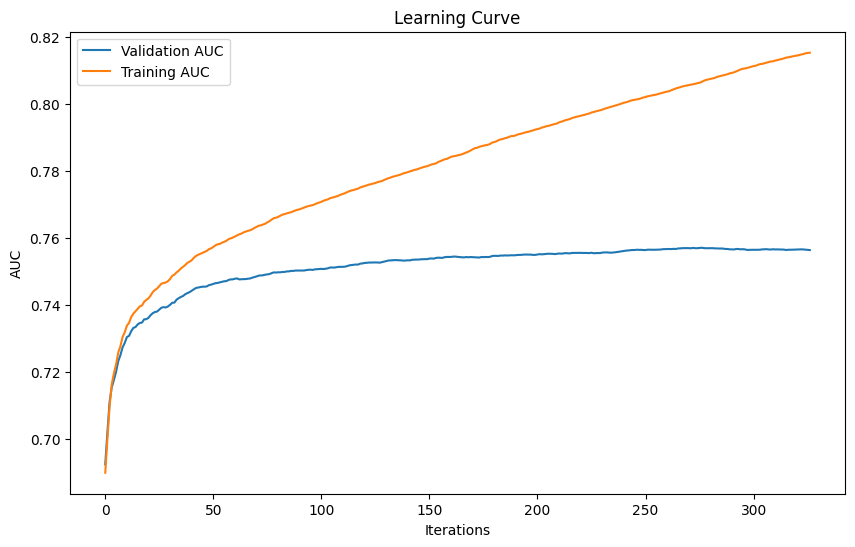

CatBoost Validation AUC: 0.7571


In [ ]:
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# モデルの設定
cat_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 10,
    'random_seed': 42
}

x_tr, x_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# データをCatBoost用に変換
train_pool = Pool(data=x_tr, label=y_tr)
valid_pool = Pool(data=x_va, label=y_va)

# モデルの訓練
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(train_pool, eval_set=[(x_tr, y_tr), (x_va, y_va)], use_best_model=True, early_stopping_rounds=50)

# 学習曲線のプロット
evals_result = cat_model.get_evals_result()

plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_1']['AUC'], label='Validation AUC')
plt.plot(evals_result['validation_0']['AUC'], label='Training AUC')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('Learning Curve')
plt.legend()
plt.show()

# モデルの評価
y_valid_pred = cat_model.predict_proba(x_va)[:, 1]
auc_score = roc_auc_score(y_va, y_valid_pred)
print("CatBoost Validation AUC: {:.4f}".format(auc_score))

In [ ]:
# テストデータをCatBoost用に変換
test_pool = Pool(data=x_test)

# テストデータでの予測
pred_cat = cat_model.predict_proba(test_pool)[:, 1]
print(pred_cat)

[0.04136156 0.30896819 0.25904955 ... 0.15314023 0.2032443  0.16949221]


In [ ]:
# すべてのモデルの予測を平均化
#final_pred = (pred_lgb + pred_xgb + pred_cat) / 3
final_pred = (pred_lgb + pred_cat) / 2

In [ ]:
# 提出ファイルの作成
submission = pd.DataFrame({
    'SK_ID_CURR': id_test['SK_ID_CURR'],
    'TARGET': final_pred
})

# ファイルの保存
submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(submission)

       SK_ID_CURR    TARGET
0          171202  0.044939
1          171203  0.325630
2          171204  0.258825
3          171205  0.146678
4          171206  0.279745
...           ...       ...
61495      232697  0.232991
61496      232698  0.056339
61497      232699  0.117874
61498      232700  0.220518
61499      232701  0.180078

[61500 rows x 2 columns]
